# 미국 중고차 가격 예측
- 조대선, 홍성현, 배준영, 유호원

# 가설
- 주행거리 5만킬로 미터 이하일때 파는게 좋을것이다.
- 지역별 가격차이가 있을것이다.
- 경제위기가 왔을때, 중고차 시장에 영향이 있을것이다.


## 데이터 출처
- Craigslist(크레이그리스트) https://craigslist.org/ : 중고 매물, 구인 구직, 주택, 자유 주제 토론등을 다루는 커뮤니티 웹사이트
- 미국내 중고차 매물 약 51만 건(업데이트 : 2020년 1월)
- 데이터 출처 : https://www.kaggle.com/austinreese/craigslist-carstrucks-data (캐글)
- Craigslist Filter 웹 애플리케이션(https://craigslist-filter.herokuapp.com/)
- 웹 애플리케이션 github : https://github.com/AustinReese/craigslistFilter (github)


<img src="./img/img2.png" width="1200">

<img src="./img/img6.png" width="1200">

#### 슬라이드쇼 할때 raw코드 안보이게 하기

In [1]:
from IPython.display import HTML

HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>'''
     )

#### 표, 마크다운 글씨 크기 조절

In [2]:
%%html
<style>
table {float:left}
table td, table th {
        border-style: solid;
        font-size: 15px;
}
li {
    font-size: 15px;
    margin:5px;
}
</style>


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow'> **price** </span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink'>**year**</span> | **entry year** | **중고차 연식**|
|<span style= 'background:#ADD8E6'>**manufacturer**</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:#ADD8E6'>**cylinders**</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:#ADD8E6'>**fuel**</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink'>**odometer**</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:#ADD8E6'>**title_status**</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:#ADD8E6'>**transmission**</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:#5aa832'>**vin**</span> |  **vehicle identification numbe**| **차대번호**|
|<span style= 'background:#ADD8E6'>**drive**</span> |  **type of drive** |**구동방식**|
|<span style= 'background:#ADD8E6'>**size**</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:#ADD8E6'>**type**</span> |  **generic type of vehicle**| **차량 타입**|
|<span style= 'background:#ADD8E6'>**paint_color**</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:#ADD8E6'>**state**</span> |  **state of listing**| **주 명**|

### **예측에 도움이 되지 않는 데이터**
|컬럼명|내용|설명|
|:------|:---|:---|
|lat|  latitude of listing| 위도|
|long |  longitude of listing| 경도|
|url |  listing  | 중고차 등록 URL |
|region |  craigslist region | 중고차 거래 지역|
|region_url |  region URL | 중고차 지역 정보 URL|
|image_url |  image URL | 중고차 사진 URL|
|description |  listed description of vehicle|  중고차 상태 설명|
|county |  useless column left in by mistake | 행정 구역 단위 (데이터 없음)|
|<span style= 'background:#ADD8E6'>**size**</span> |  **size of vehicle** | **차량 크기, 모델 성능 비교 결과에 근거** |
|<span style= 'background:#ADD8E6'>**condition**</span> |  **condition of vehicle** | **차량 상태, 모델 성능 비교 결과에 근거**|
|model |  model of vehicle| 차량 모델명, 다른 feature들의 대표성을 띄는 데이터 (다중 공선성 발생)|

# 데이터 탐색

In [1]:
# 사용되는 패키지
import re
import missingno as msno
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# 컬럼 display 제한 상향
pd.set_option('display.max_columns', 500)

# 지수 표기법 해제
pd.options.display.float_format = '{:.5f}'.format

In [2]:
raw_data = pd.read_csv("vehicles.csv")

In [3]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','vin']]

In [4]:
start_df.shape

(509577, 14)

### 결측치 확인

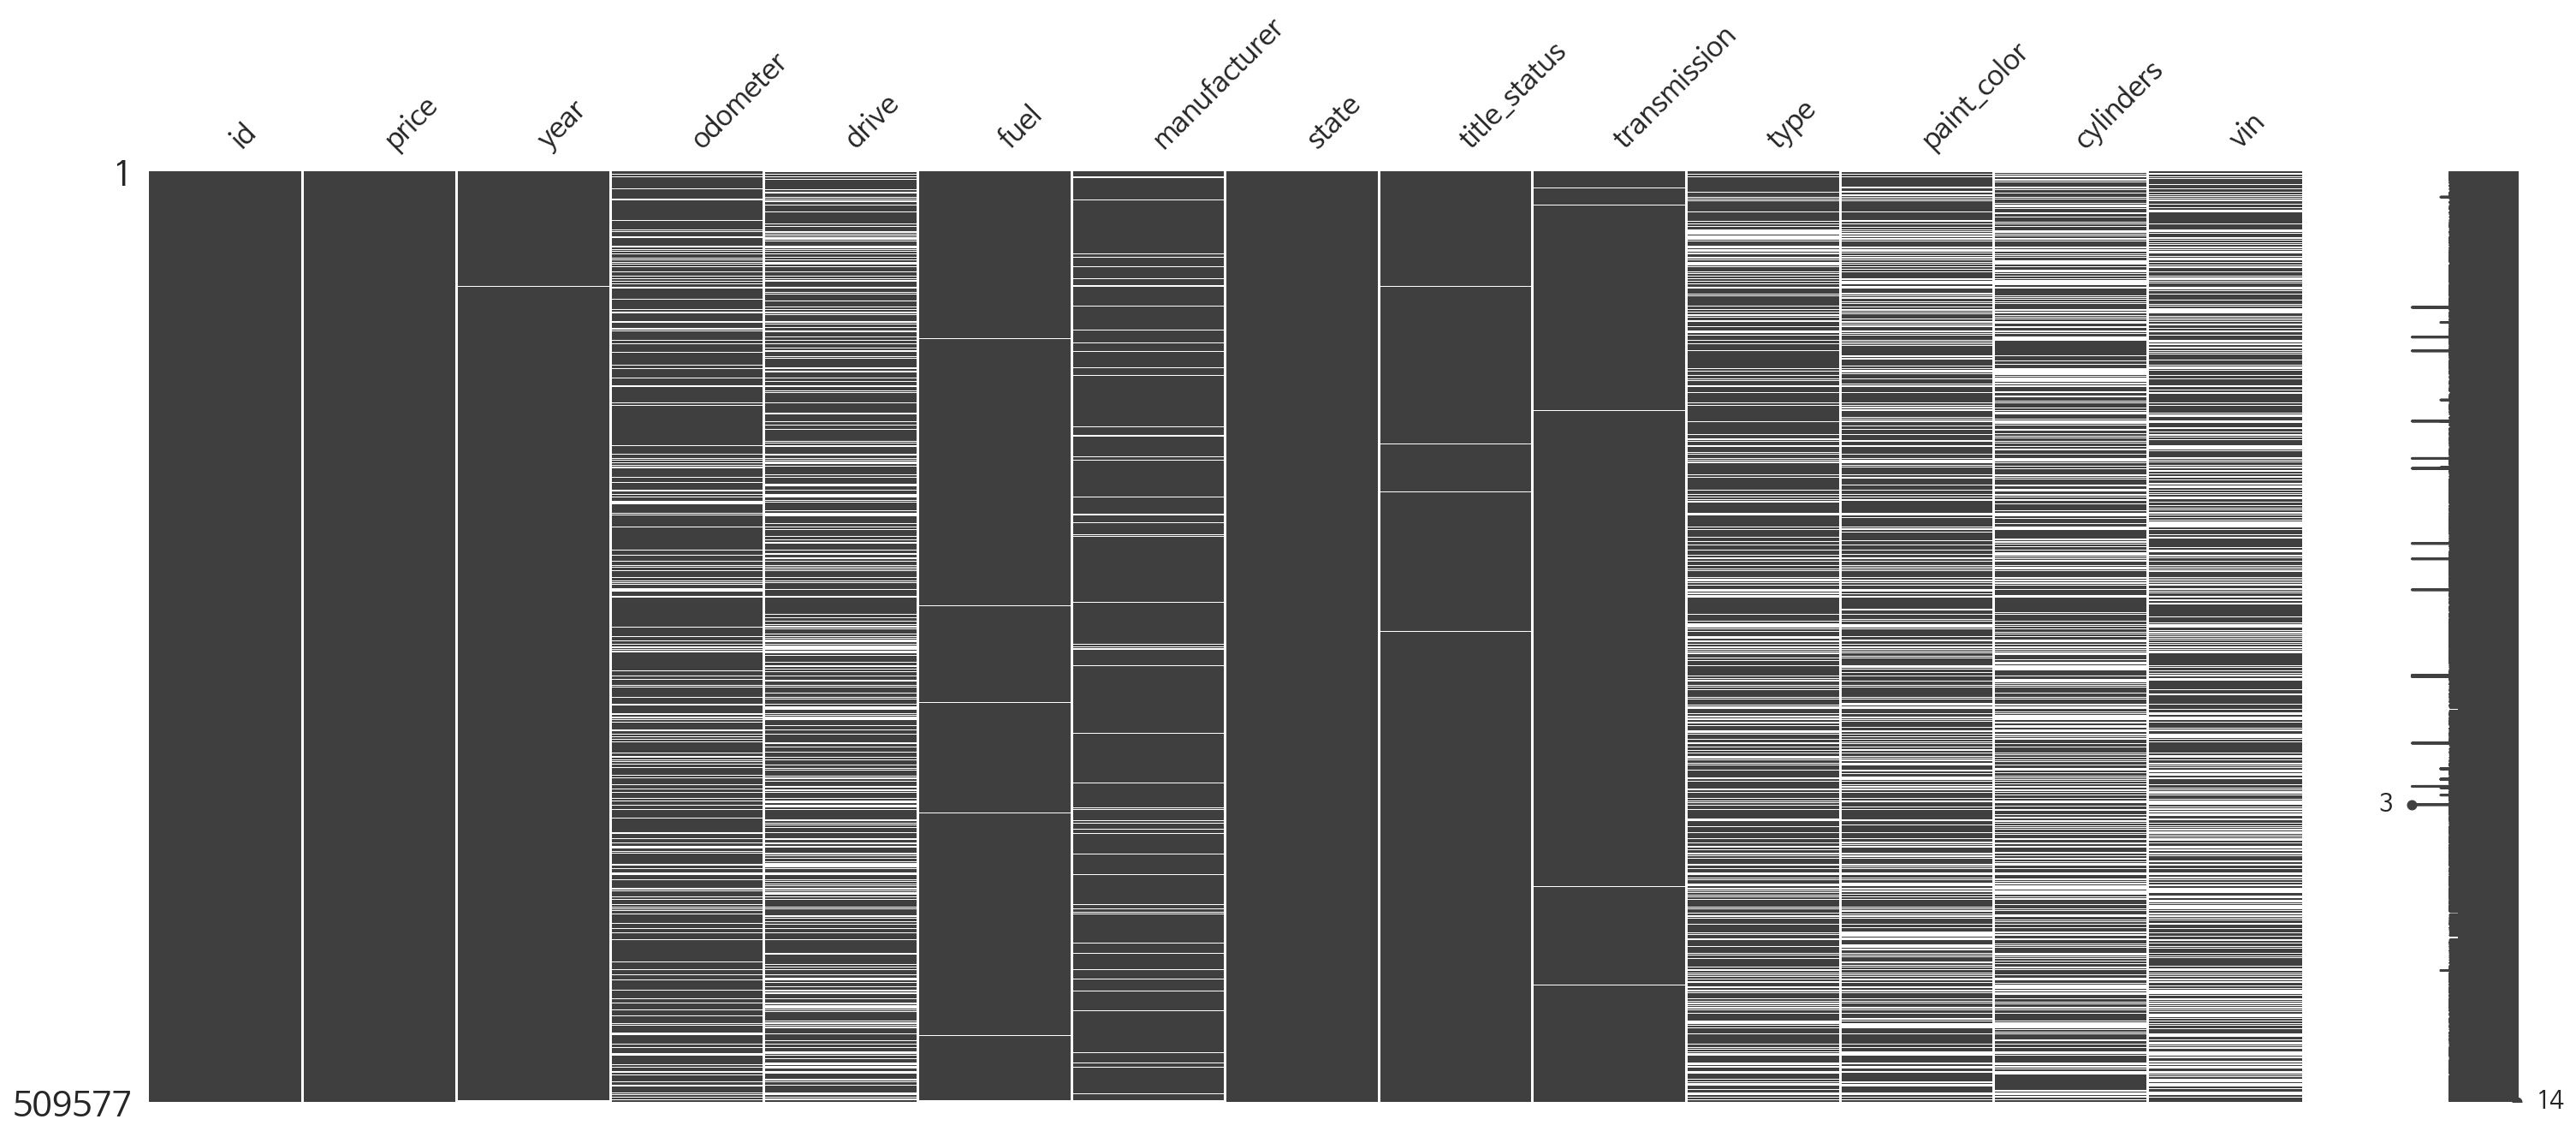

In [5]:
msno.matrix(start_df)
plt.show()

#### 결측치 수치화

In [6]:
def columns_na_percentage(df,columns):
    for column in columns:
        percentage = round(100 -(len(df['{}'.format(column)].dropna()) / len(df)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

            
columns_na_percentage(start_df ,start_df.columns)

year :  0.3 %
odometer :  18.12 %
drive :  28.29 %
fuel :  0.78 %
manufacturer :  4.47 %
title_status :  0.6 %
transmission :  0.73 %
type :  27.77 %
paint_color :  32.32 %
cylinders :  39.19 %
vin :  40.71 %


### 결측치 제거

In [7]:
start_df = start_df.dropna(axis=0)
start_df.shape

(120609, 14)

## 차대 번호(vin)를 활용한 데이터 필터링

### 데이터 전처리전 price

<img src="./img/img7.png" width="1000">

### **Step1**
  - 중복된 'vin'을 가지고 있는 데이터 삭제

In [8]:
start_df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
start_df.shape

(77678, 14)

### **Step2**
 - 'vinaudit.com'이 제공하는 api를 이용
     <img src="./img/img1.png" width="850" style="float:left">

- **데이터 출처**
    - 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
    - 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
    - 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA) 
    - 그외 미국 정부 기관과 관련된 업체 및 파트너사

## 크롤링 데이터 분석

|컬럼명|설명|
|:------|:---|
| **above** | 최대 가격|
|**average** | 평균 가격|
|**below** | 최소 가격 |
|**certainty** | 정확도 |
|**count**|  거래 횟수|
|**error** |  에러 메세지 |
|**mileage**|  주행 거리 |
|**period**|  거래 시기|
|**stdev**|  표준 편차|
|**success**|  성공 여부|
|**vehicle**|  차량 정보 (연식, 제조사, 모델명)|

<img src="./img/img3.png" width="800">

- **데이터 사용처**
    - Vincheck등 중고차 매물 검색 업체
<img src="./img/img5.png" width="250">    
    - NICB (National Insurance Crime Bureau) 등
<img src="./img/img4.png" width="200">

### 크롤링 데이터를 활용한 데이터 필터링

In [9]:
start_df.shape

(77678, 14)

In [10]:
vin_crawling_data = pd.read_csv('./final_vin_crawling.csv')
# secend_half_crawling_data = pd.read_csv('./vin_crawling_addtional.csv')
# vin_crawling_data = pd.concat([first_half_crawling_data, secend_half_crawling_data], axis=0)

# 대문자 변경
vin_crawling_data['vin'] = vin_crawling_data['vin'].str.upper()

# 중복제거
vin_crawling_data = vin_crawling_data.drop_duplicates('vin',keep='first')

# 대문자 변경
start_df['vin'] = start_df['vin'].str.upper()

# merge
merged_df = pd.merge(start_df,vin_crawling_data,on='vin')

# 중복 제거
merged_df = merged_df.drop_duplicates('vin',keep='first')

# 필요 없는 컬럼 제거
df = merged_df[merged_df.columns.difference(['id_y','id_x','Unnamed: 0','Unnamed: 0.1','og_vin'])]
df.shape

(77569, 25)

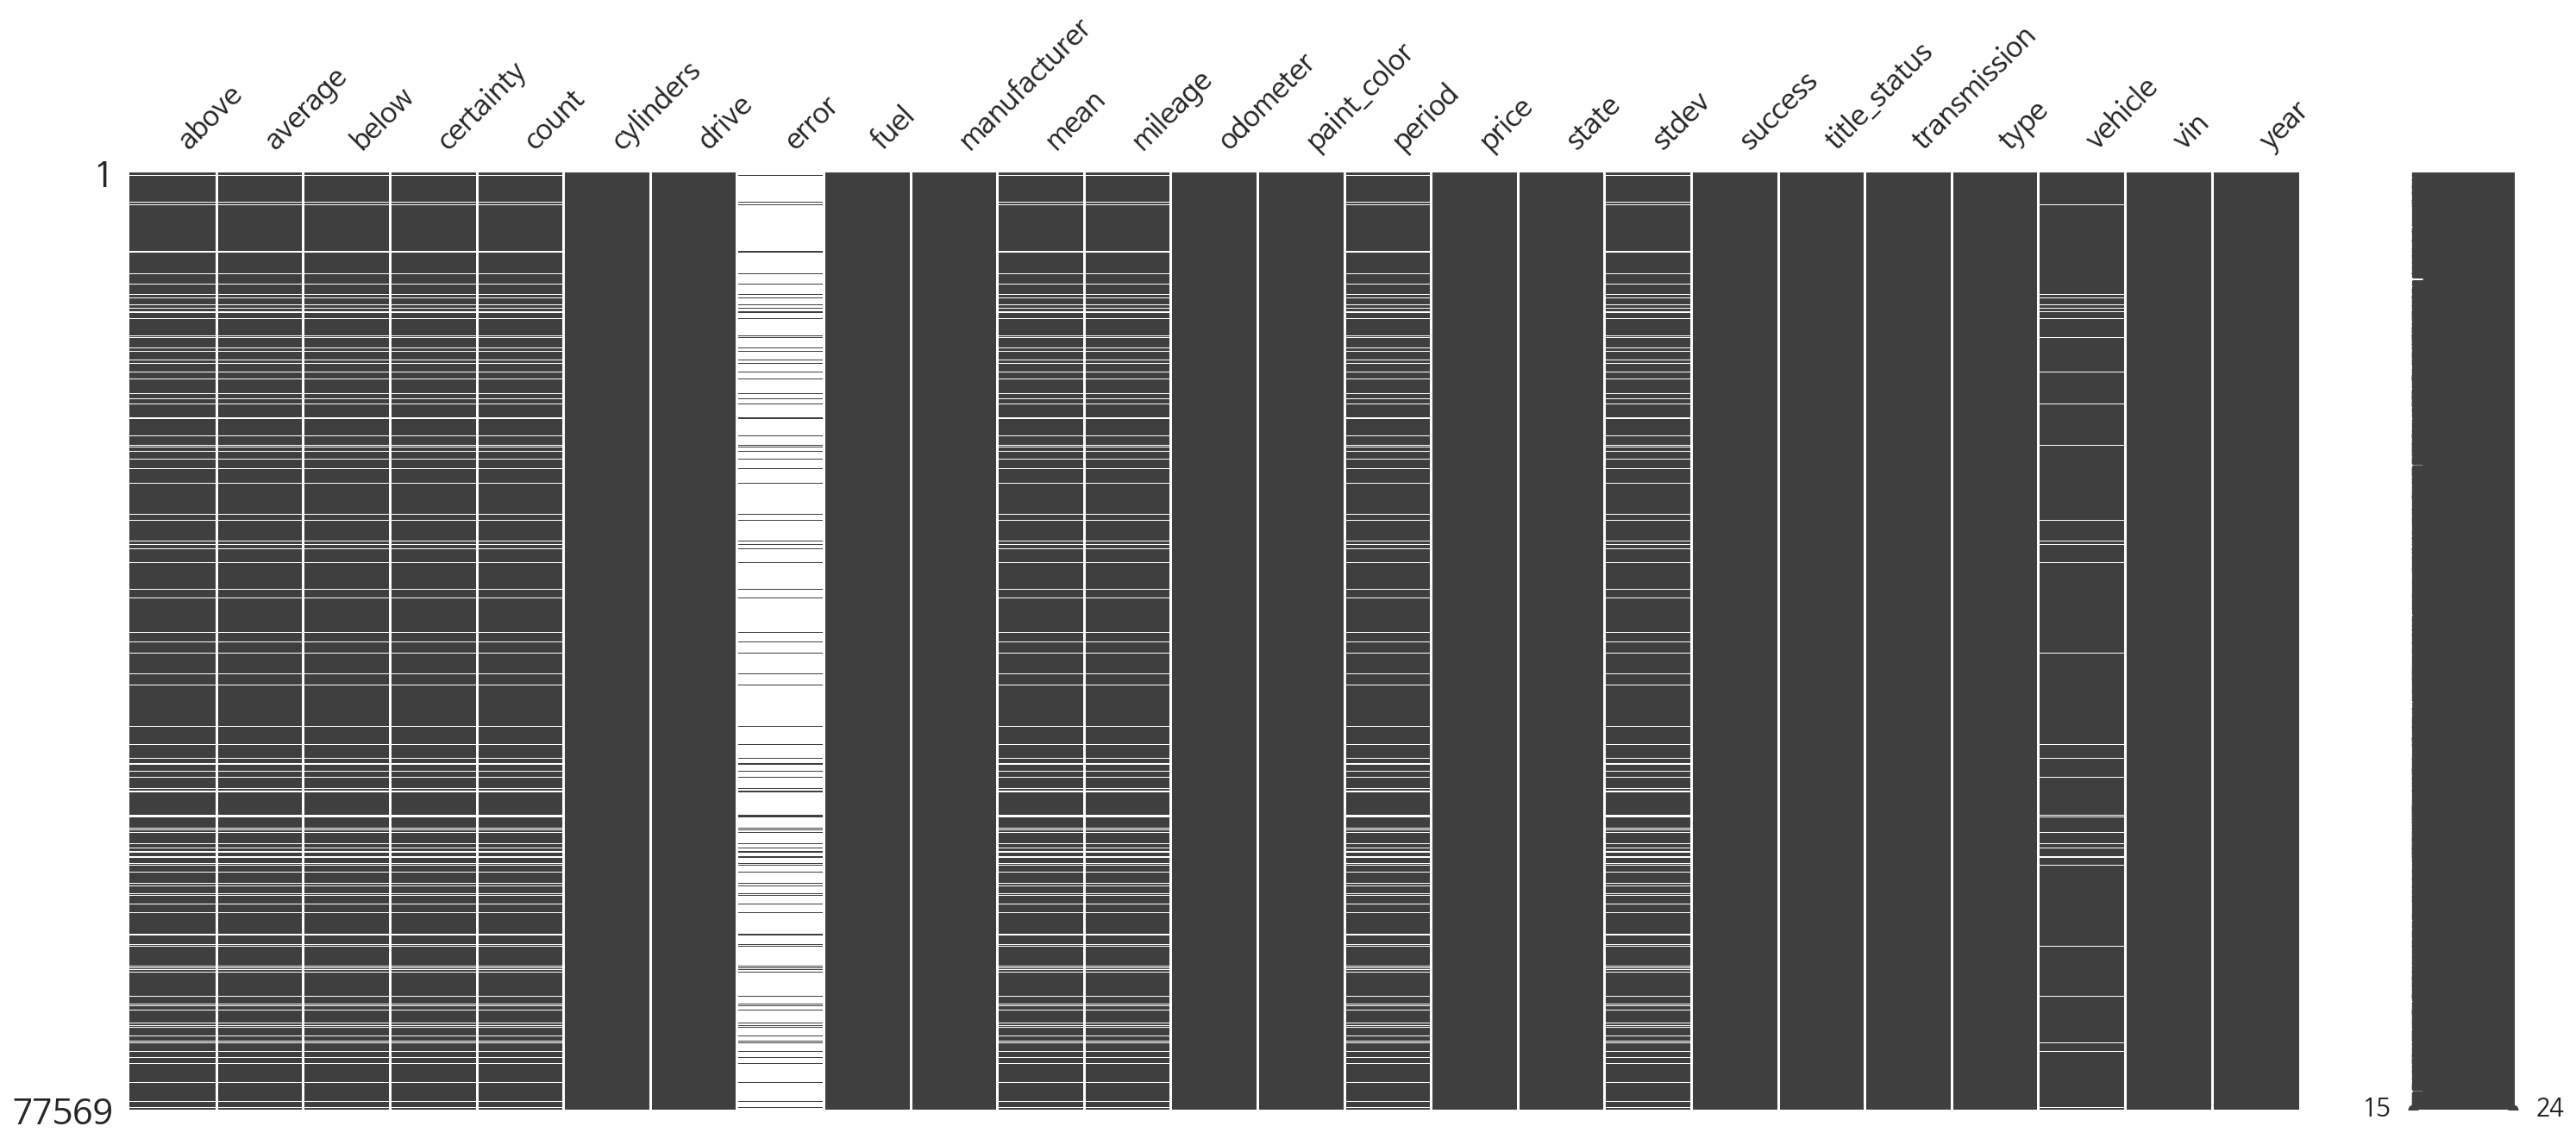

In [11]:
msno.matrix(df)
plt.show()

### error 컬럼 
- 'no_data' : request시에 던져준 'odometer'가 잘못되어 정보를 가져올수 없는 경우, 즉 이력조회가 되지않는 차량
- 'invalid_vin' : request시에 던져준 'vin'이 17자리가 아닌 경우
  - 1980년도 이전에 생산된 차량의 정보는 데이터베이스화 되어있지 않음
  - 판매자가 잘못된 vin값을 입력한 경우

In [12]:
df['error'].value_counts()

no_data        4263
invalid_vin    3038
Name: error, dtype: int64

- 'error'값을 가지고 있는 row들을 제거

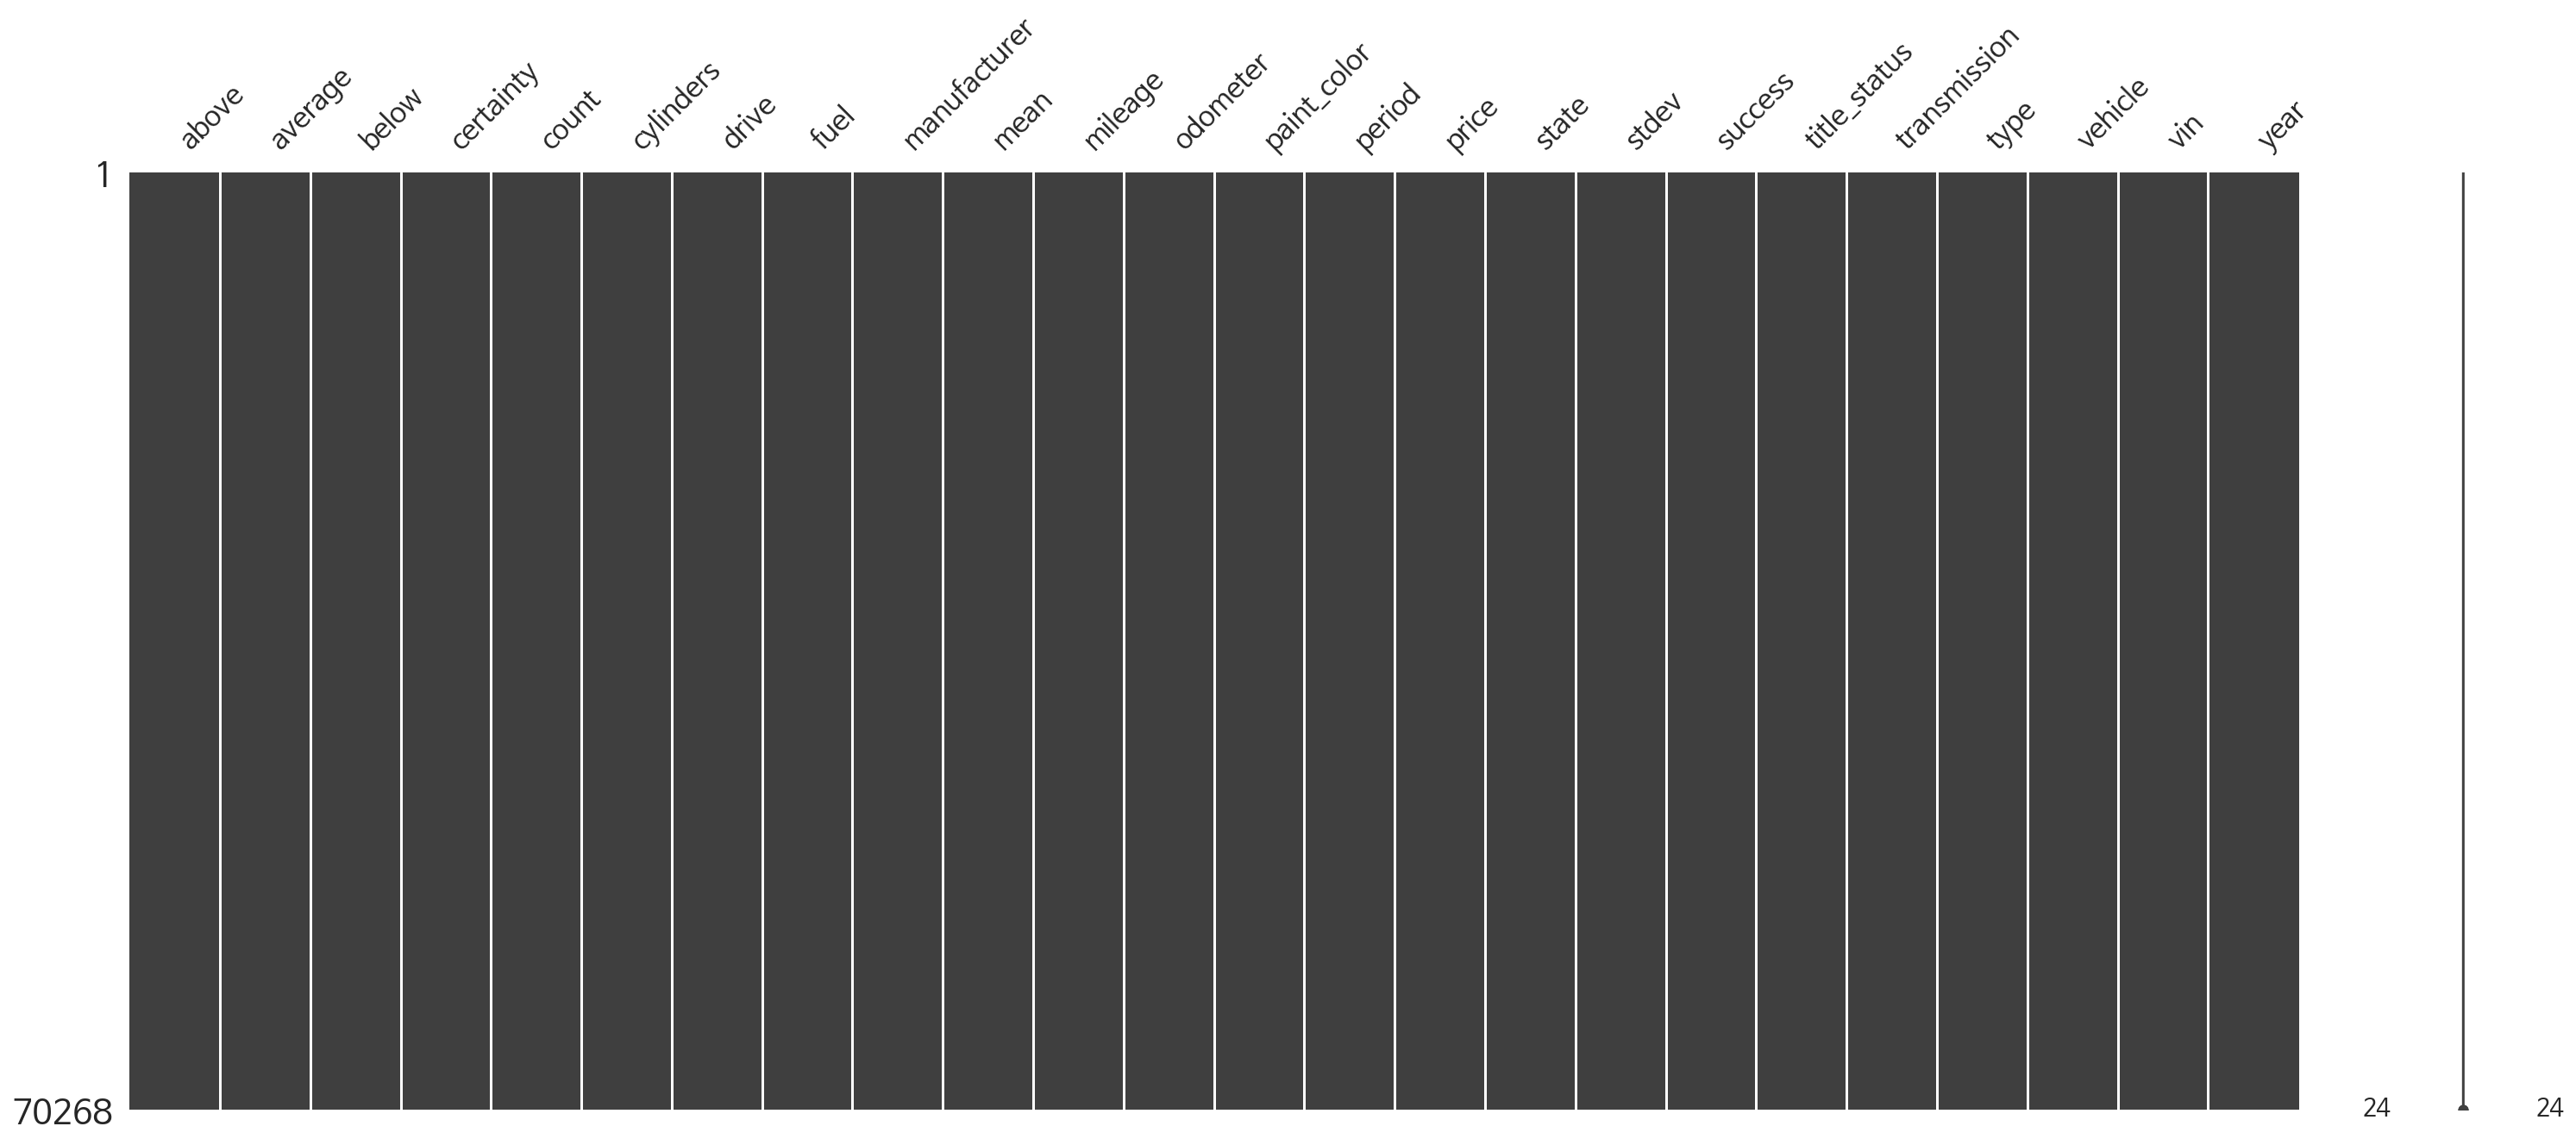

In [13]:
df=df[df.columns.difference(['error'])]
df = df.dropna(axis=0)
msno.matrix(df)
plt.show()

# 아웃라이어 탐색

### 가격 아웃라이어 탐색

- 평균가격과 표준편차를 이용해 'price'의 아웃라이어를 필터링

In [14]:
df[['above', 'average', 'below','stdev']].head(2)

,above,average,below,stdev
0,20878.90000,18399.90000,15920.90000,2479.00000
1,8113.75000,6710.75000,5307.75000,1403.00000


### 평균값과 표준편차를 이용한 데이터 필터링

In [15]:
def get_sigma_data_by_price(num):
    # price가 0인것들 제거
    sigma = df[(df['price'] >= (df['average'] - (df['stdev']*num))) & (df['price'] <= (df['average'] + (df['stdev']*num)))]
    print("{} sigma data : ".format(num),sigma.shape)
    return sigma

sigma_2_df = get_sigma_data_by_price(2)
sigma_2_df.shape

2 sigma data :  (56026, 24)


(56026, 24)

In [16]:
# year를 int로 형변환
sigma_2_df['year'] = sigma_2_df['year'].astype('int')

### 주행거리 아웃라이어 탐색
- odometer와 mileage가 다른 데이터 : 판매자가 과도하게 높은 odometer를 입력한 경우

In [17]:
print("주행거리가 잘못 입력된 차량 대수 : ",len(sigma_2_df[sigma_2_df['mileage'] != sigma_2_df['odometer']]))
sigma_2_df[sigma_2_df['mileage'] != sigma_2_df['odometer']].sort_values(ascending=False,by='odometer').head(2)

주행거리가 잘못 입력된 차량 대수 :  31


,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
51426,10244.99000,8898.99000,7552.99000,81.70000,9.00000,6 cylinders,4wd,gas,lexus,8898.99000,148490.00000,4706000.00000,custom,"['2019-10-02', '2020-03-07']",8000,nc,1346.00000,True,clean,automatic,SUV,2007 Lexus RX 400h Base,JTJHW31UX72010051,2007
8407,5276.60000,4335.60000,3394.60000,65.00000,4.00000,8 cylinders,4wd,gas,dodge,4335.60000,180265.00000,4000085.00000,custom,"['2019-10-05', '2020-01-15']",3995,al,941.00000,True,clean,automatic,SUV,2004 Dodge Durango SLT,1D4HB48N44F169643,2004


In [18]:
# 주행거리 아웃라이어 제거
sigma_2_df = sigma_2_df[sigma_2_df['mileage'] == sigma_2_df['odometer']]

### 박스플롯, 스캐터 플롯

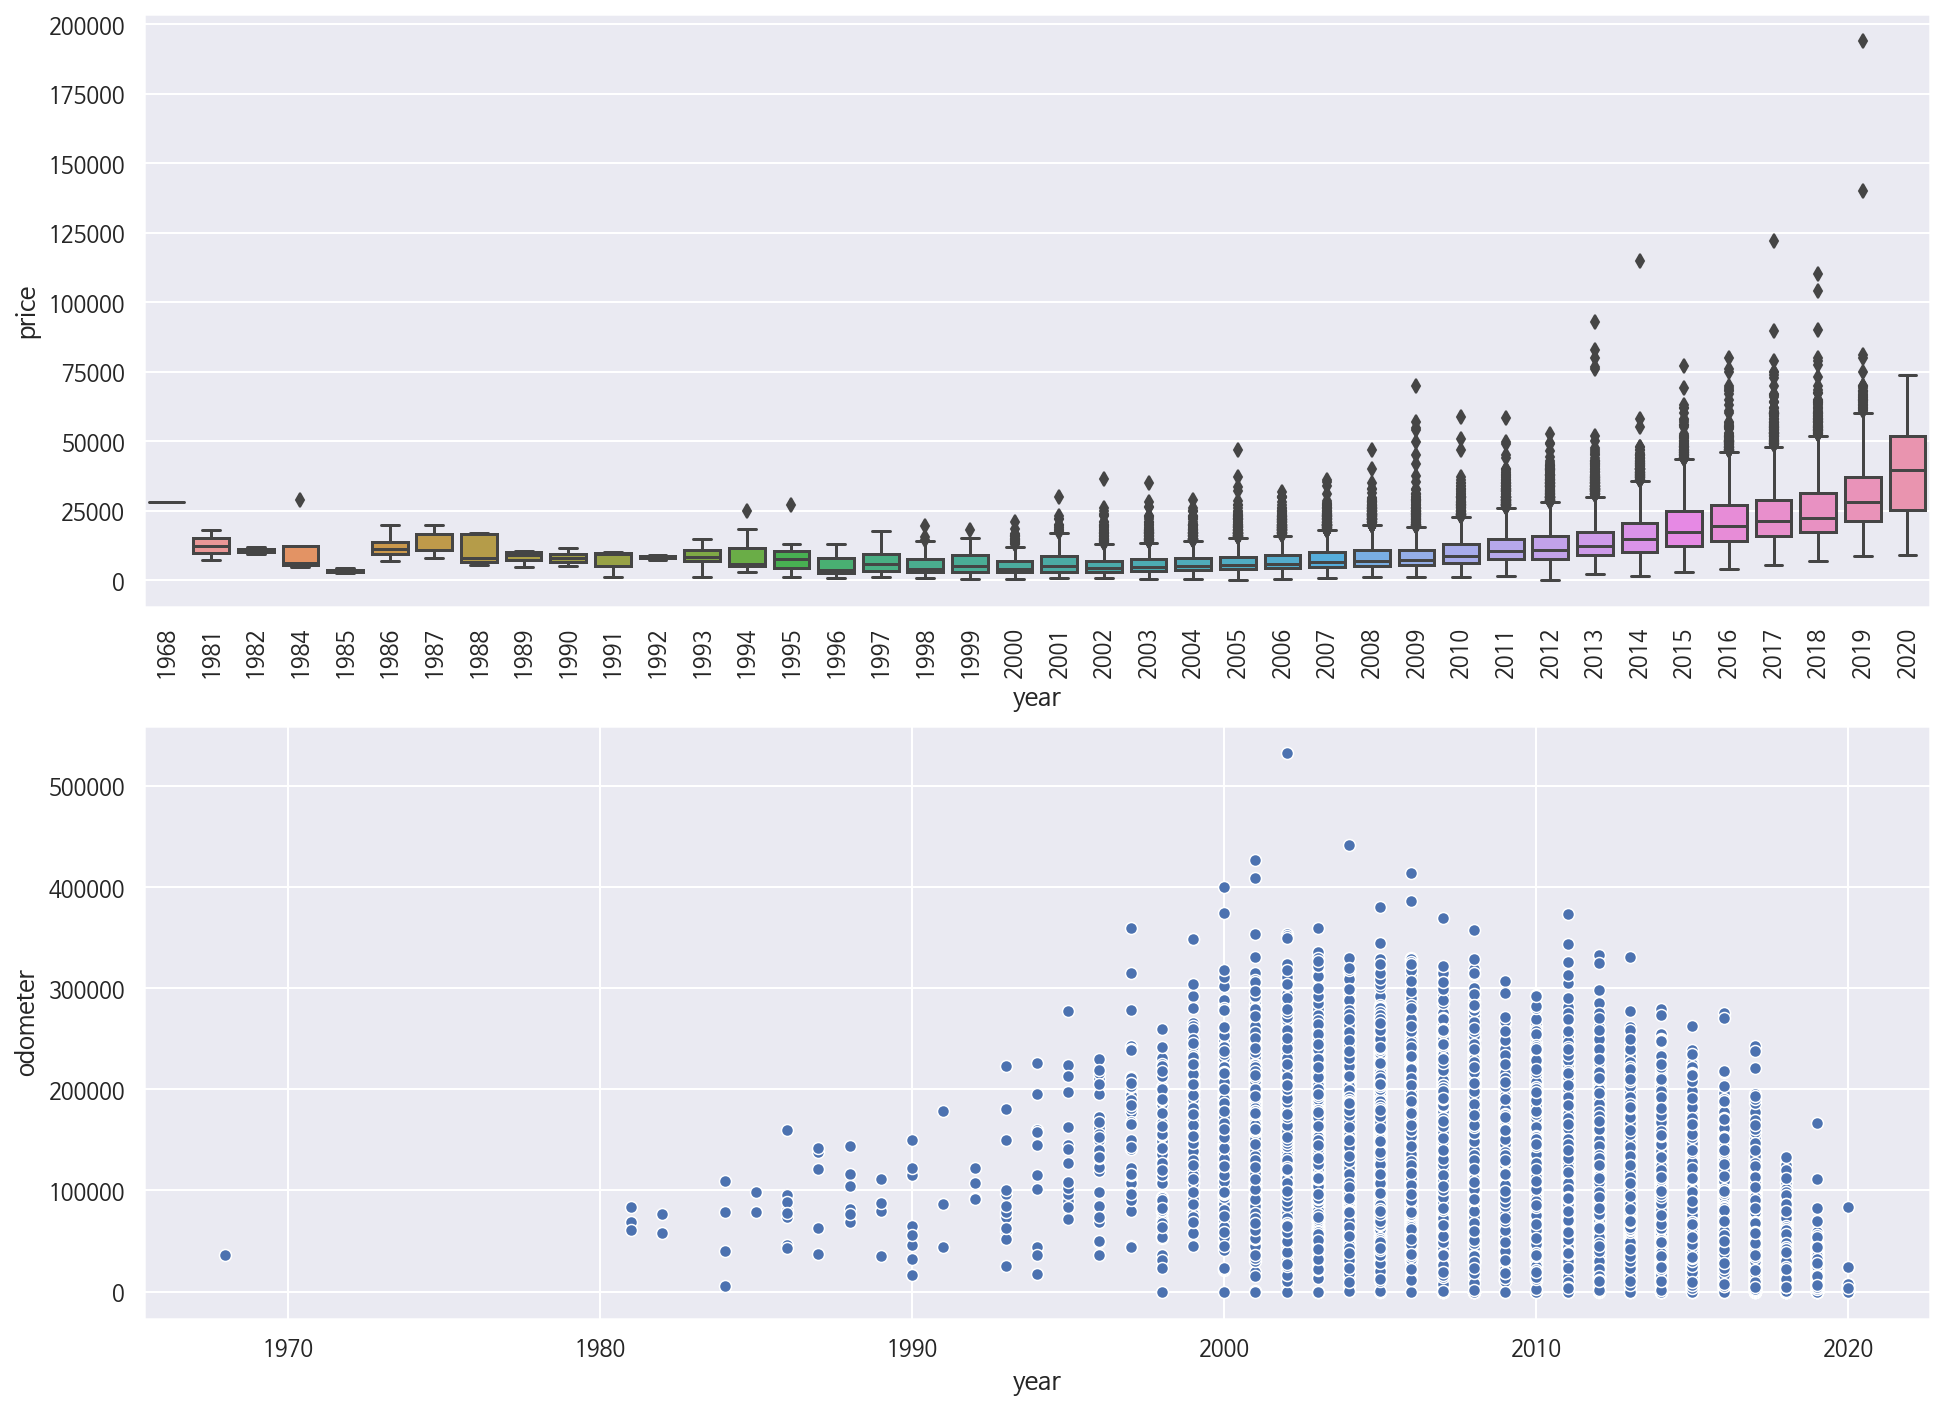

In [19]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.boxplot(x="year", y="price", data = sigma_2_df)
plt.xticks(rotation=90)
plt.subplot(212)
sns.scatterplot(sigma_2_df['year'],sigma_2_df['odometer'])
# plt.subplot(313)
# sns.scatterplot(test2['year'],test2['price'])

plt.show()

## 플롯 그린후 눈으로 본 데이터

- 연도

In [20]:
# year 수정해 줘야 하는 데이터
sigma_2_df[sigma_2_df['year'] < 1980]

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
49431,31752.09000,28691.09000,25630.09000,99.00000,240.00000,8 cylinders,rwd,gas,pontiac,28691.09000,36211.00000,36211.00000,blue,"['2019-12-14', '2020-03-26']",27988,mt,3061.00000,True,clean,automatic,other,2019 Toyota Sienna,5TDYZ3DC0KS008940,1968


In [21]:
sigma_2_df['year'] = sigma_2_df['year'].apply(lambda x : 2019 if x < 1980 else x)

- 주행거리

In [22]:
sigma_2_df[sigma_2_df['odometer'] > 500000]

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
28776,9045.70000,6984.70000,4923.70000,65.00000,4.00000,8 cylinders,4wd,gas,toyota,6984.70000,533000.00000,533000.00000,grey,"['2019-10-03', '2020-02-20']",6500,ga,2061.00000,True,clean,automatic,SUV,2002 Toyota Land Cruiser Base,JTEHT05J722017912,2002


In [23]:
# 약 18년간 운행한 자동차의 일 평균 주행거리 계산
print("평균 주행거리 : ", round(533000.00 / (365* 18),2),"마일/day")

평균 주행거리 :  81.13 마일/day


- 가격
  - 75000불 초과 차량 확인

In [24]:
sigma_2_df[sigma_2_df['price'] > 75000].sort_values(by=['price'],ascending=False).head()

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
60128,202032.56000,182660.56000,163288.56000,90.00000,16.00000,8 cylinders,4wd,gas,mercedes-benz,182660.56000,7584.00000,7584.00000,white,"['2019-10-03', '2020-03-26']",193982,oh,19372.00000,True,clean,automatic,SUV,2019 Mercedes-Benz,WDCYC7HJ3KX301396,2019
29627,149400.58000,132238.58000,115076.58000,70.30000,5.00000,3 cylinders,4wd,hybrid,bmw,132238.58000,649.00000,649.00000,grey,"['2019-10-05', '2020-03-14']",139995,hi,17162.00000,True,clean,automatic,convertible,2019 BMW,WBY2Z6C52KVB82784,2019
20351,130595.38000,124912.38000,119229.38000,79.60000,8.00000,10 cylinders,4wd,gas,audi,124912.38000,25624.00000,25624.00000,red,"['2019-10-06', '2020-03-19']",121995,co,5683.00000,True,clean,automatic,coupe,2017 Audi R8 (V10 quattro),WUAEAAFX4H7901309,2017
10976,125445.67000,119893.67000,114341.67000,74.20000,6.00000,8 cylinders,rwd,gas,ferrari,119893.67000,12986.00000,12986.00000,black,"['2019-10-03', '2020-03-22']",114950,az,5552.00000,True,clean,automatic,convertible,2014 Ferrari California Base,ZFF65TJAXE0200770,2014
73531,117293.94000,105051.94000,92809.94000,90.70000,17.00000,8 cylinders,rwd,gas,mercedes-benz,105051.94000,5560.00000,5560.00000,black,"['2019-10-01', '2020-03-26']",109995,tx,12242.00000,True,clean,automatic,convertible,2018 Mercedes-Benz AMG GT Base,WDDYK7HA6JA014263,2018


- 500불 미만 차량 확인

In [25]:
sigma_2_df[sigma_2_df['price'] < 500].sort_values(by=['price'],ascending=False)

,above,average,below,certainty,count,cylinders,drive,fuel,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
22916,1708.69000,1139.69000,570.69000,57.30000,3.00000,4 cylinders,4wd,gas,honda,1139.69000,380774.00000,380774.00000,silver,"['2020-02-21', '2020-03-11']",390,de,569.00000,True,clean,automatic,sedan,2005 Honda Civic LX,2HGES16695H615734,2005
39176,280.57000,242.57000,204.57000,44.30000,2.00000,8 cylinders,fwd,gas,lincoln,242.57000,180000.00000,180000.00000,red,"['2019-11-01', '2019-12-04']",300,la,38.00000,True,clean,automatic,sedan,1999 Lincoln Continental Base,1LNHM97V3XY629191,1999
38722,18636.20000,12424.20000,6212.20000,44.30000,2.00000,8 cylinders,rwd,other,chevrolet,12424.20000,158389.00000,158389.00000,white,"['2019-10-10', '2019-10-10']",150,ky,6212.00000,True,clean,automatic,van,2012 Chevrolet Express Cargo 2500,1GCWGFBA7C1155304,2012
38633,11662.95000,7775.95000,3888.95000,44.30000,2.00000,8 cylinders,rwd,other,chevrolet,7775.95000,220790.00000,220790.00000,white,"['2019-10-10', '2019-10-10']",131,ky,3887.00000,True,clean,automatic,van,2012 Chevrolet Express Cargo 2500,1GCWGFBA8C1126880,2012
24512,4792.78000,3195.78000,1598.78000,44.30000,2.00000,6 cylinders,fwd,gas,ford,3195.78000,146221.00000,146221.00000,white,"['2019-10-08', '2019-10-15']",85,fl,1597.00000,True,clean,automatic,SUV,2005 Ford Escape XLT,1FMCU03115KA47874,2005


In [26]:
# 이상치 가격을 보이는 차량 제거
sigma_2_df = sigma_2_df[(sigma_2_df['vin'] != '1GCWGFBA7C1155304') & (sigma_2_df['vin'] != '1GCWGFBA8C1126880') & (sigma_2_df['vin'] != '1FMCU03115KA47874')]

### 값이 0인 데이터 제거
- price, odometer 값이 0인 경우 제거

In [27]:
print("판매자가 주행거리를 0으로 올려둔 경우 : ",len(sigma_2_df[sigma_2_df['odometer'] == 0]),"건")
sigma_2_df[sigma_2_df['odometer'] == 0].head(2)
sigma_2_df= sigma_2_df[sigma_2_df['odometer'] != 0]

판매자가 주행거리를 0으로 올려둔 경우 :  50 건


In [28]:
# vinaudit에서 가격을 예측 했으나, 판매자가 가격을 매기지 않고 0이라고 올려둔 경우
print("판매자가 가격을 매기지 않고 0이라고 올려둔 경우 : ",len(sigma_2_df[sigma_2_df['price'] == 0]),"건")
sigma_2_df[sigma_2_df['price'] == 0].head(2)
sigma_2_df= sigma_2_df[sigma_2_df['price'] != 0]

판매자가 가격을 매기지 않고 0이라고 올려둔 경우 :  0 건


### column 정리
- 분석에 필요한 컬럼

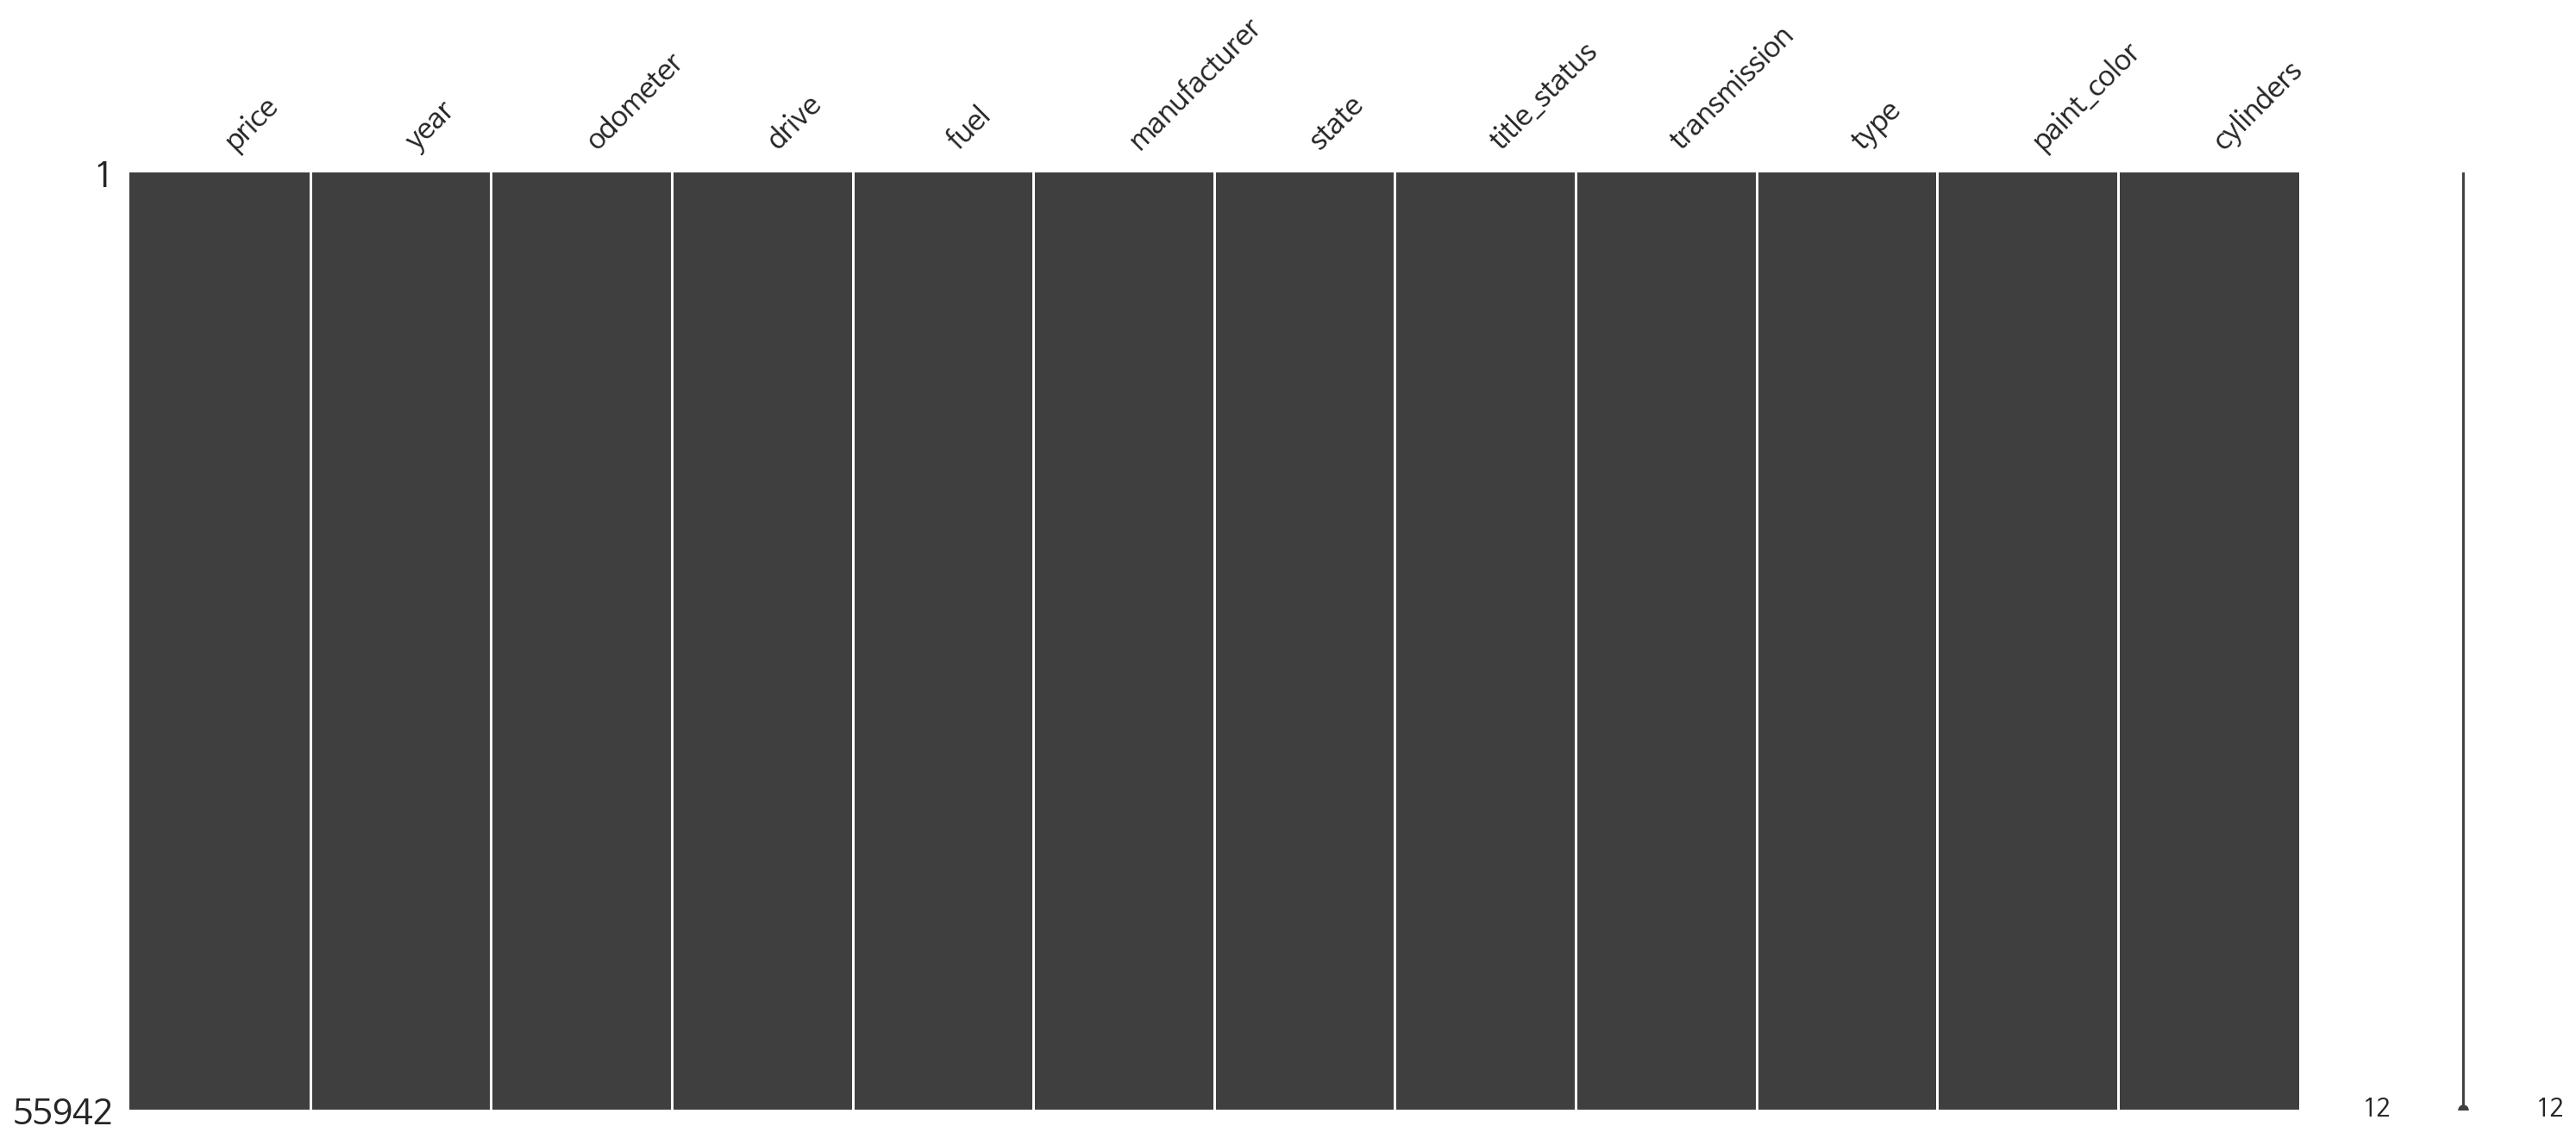

In [29]:
df = sigma_2_df[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
df = df.reset_index(drop=True)
msno.matrix(df)
plt.show()

# 변수탐색

## 종속변수 - 가격(price)

In [752]:
df.price.sort_values(ascending=False)[:20]

43793    193982
21387    139995
14953    121995
8499     114950
53103    109995
10835    103999
45103     92991
21529     89995
11929     89800
44959     82991
21359     80905
55921     79997
41133     79995
9982      79990
14564     79970
13568     78988
47094     78900
10621     77500
22379     76993
30253     76525
Name: price, dtype: int64

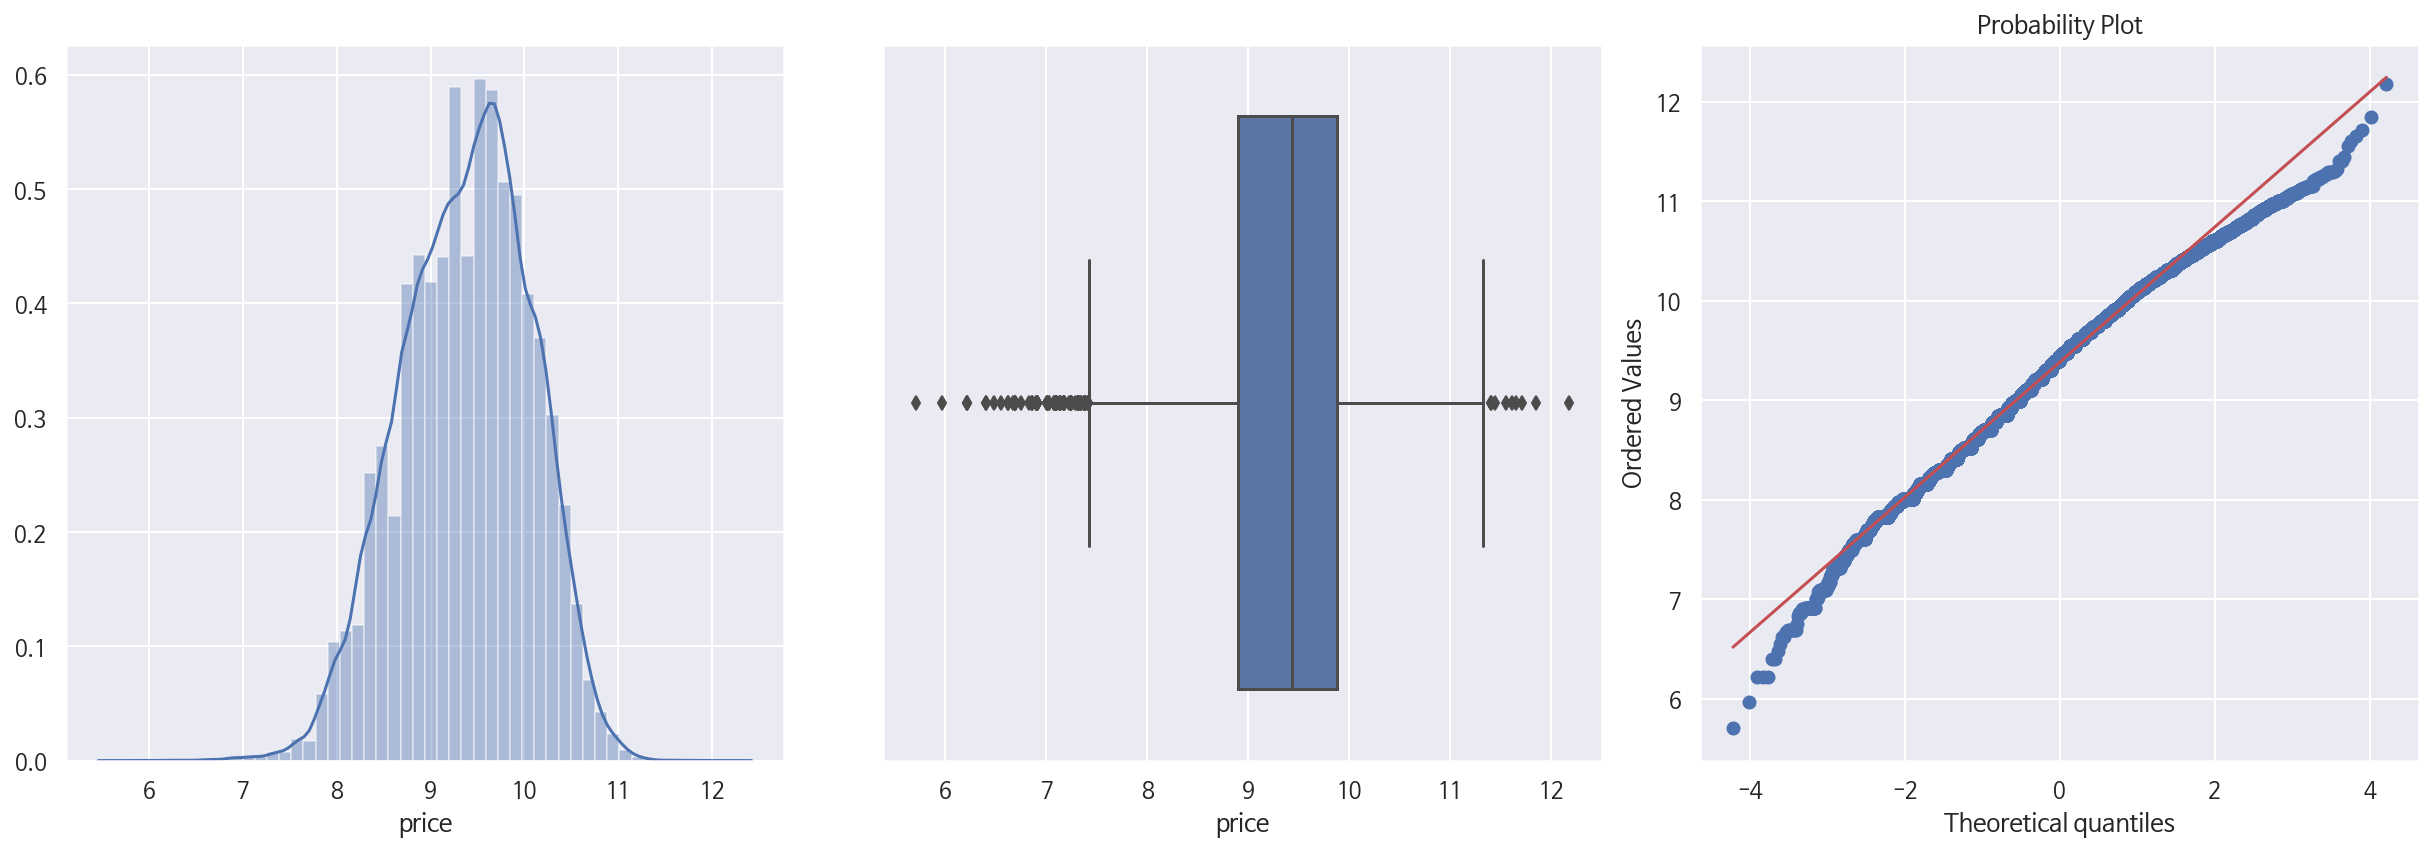

In [753]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(df['price']))

plt.subplot(132)
sns.boxplot(np.log(df['price']))

plt.subplot(133)
stats.probplot(np.log(df['price']),plot=plt)
plt.tight_layout()
plt.show()

## 독립변수

### 연식 - yaer

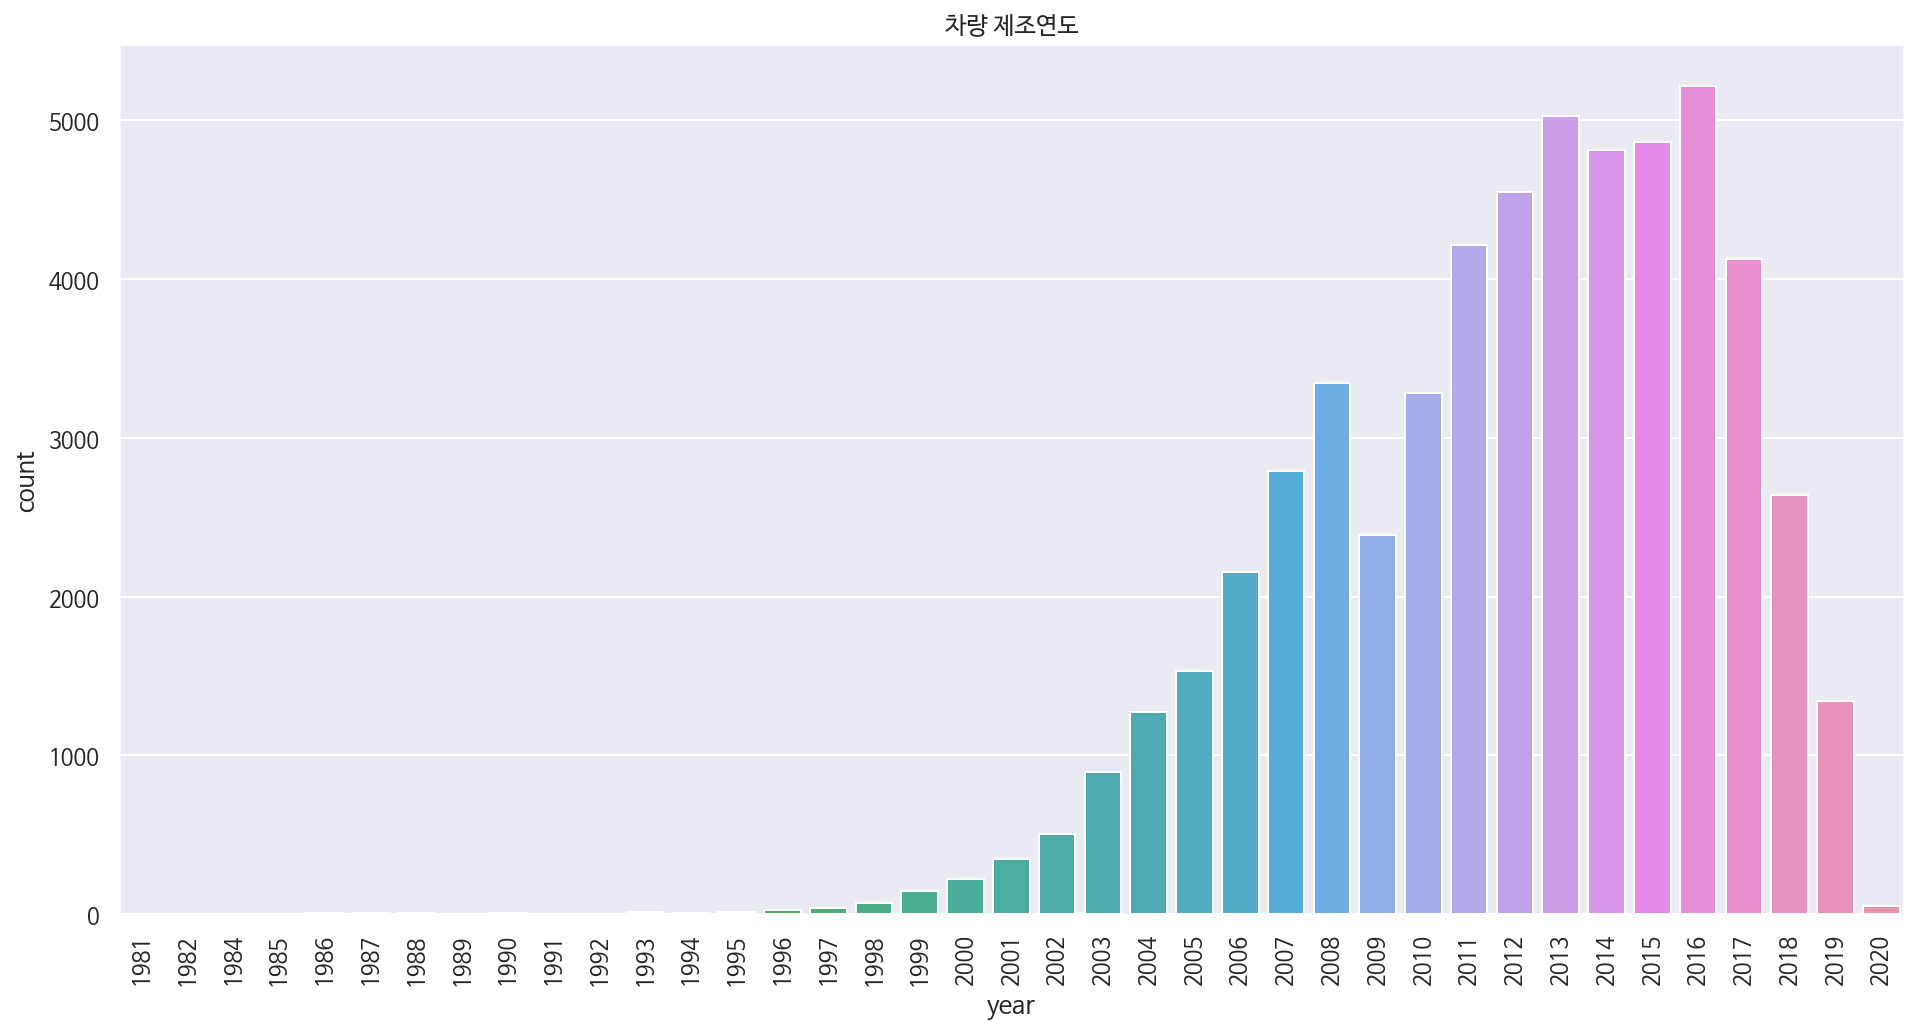

In [754]:
plt.figure(figsize=(16,8))
sns.countplot(
    df['year']
)
plt.title("차량 제조연도")
plt.xticks(rotation=90)
plt.show()

### 가설 3
- 경제위기가 왔을때, 중고차 시장에 영향이 있을것이다.

<img src="./img/8.png" width="1000">

#### 당시 미국 자동차 업계의 상황
- 2007년 서브프라임 모기지(비우량 주택 담보 대출) 부실 사태로 촉발된 글로벌 금융 위기 발생
- 2008년 리먼브라더스 파산으로 확산, 그 여파로 미국 자동차 BIG3(GM, Ford, Chrysler)가 파산 위기에 놓임.

- 미국정부가 2008년 12월 GM과 크라이슬러에 총 800억 달러 규모 구제금융 지원. 지원 조건으로 정부 관할하 대규모 구조조정

- GM : 2009년 6월 파산보호 신청. 산하 모기지 금융 기관의 서브프라임 모기지 디폴트로 약 10억 달러의 피해 포함 총 309억달러 피해로 구제 금융 요청. 주가 86% 까지 하락. 미 정부의 자금 지원과 대규모 구조조정 등으로 약 3년만에 회생

- Ford : 금융위기 당시 유일하게 파산보호신청을 면하고 공적 자금 없이 버텼으나 2007년부터 2010년에 걸쳐 포드와 링컨 브랜드 제외한 볼보·재규어·랜드로버·에스턴마틴 매각. 금융위기 이후 방대했던 모델과 플랫폼 통함을 골자로 하는 ‘원 포드(One Ford)’ 전략 추진으로 재도약

- Chrysler: 2009년 4월 파산보호 신청. 당시 Chrysler 납품업체 60% 이상이 GM과 Ford에도 납품하고 있었기 때문에 연쇄 작용. 정부가 구제금융 지원해주며 독자적 생존 능력 부족을 이유로 이탈리아 피아트 지분 참여시킴.

### 주행거리 - odometer

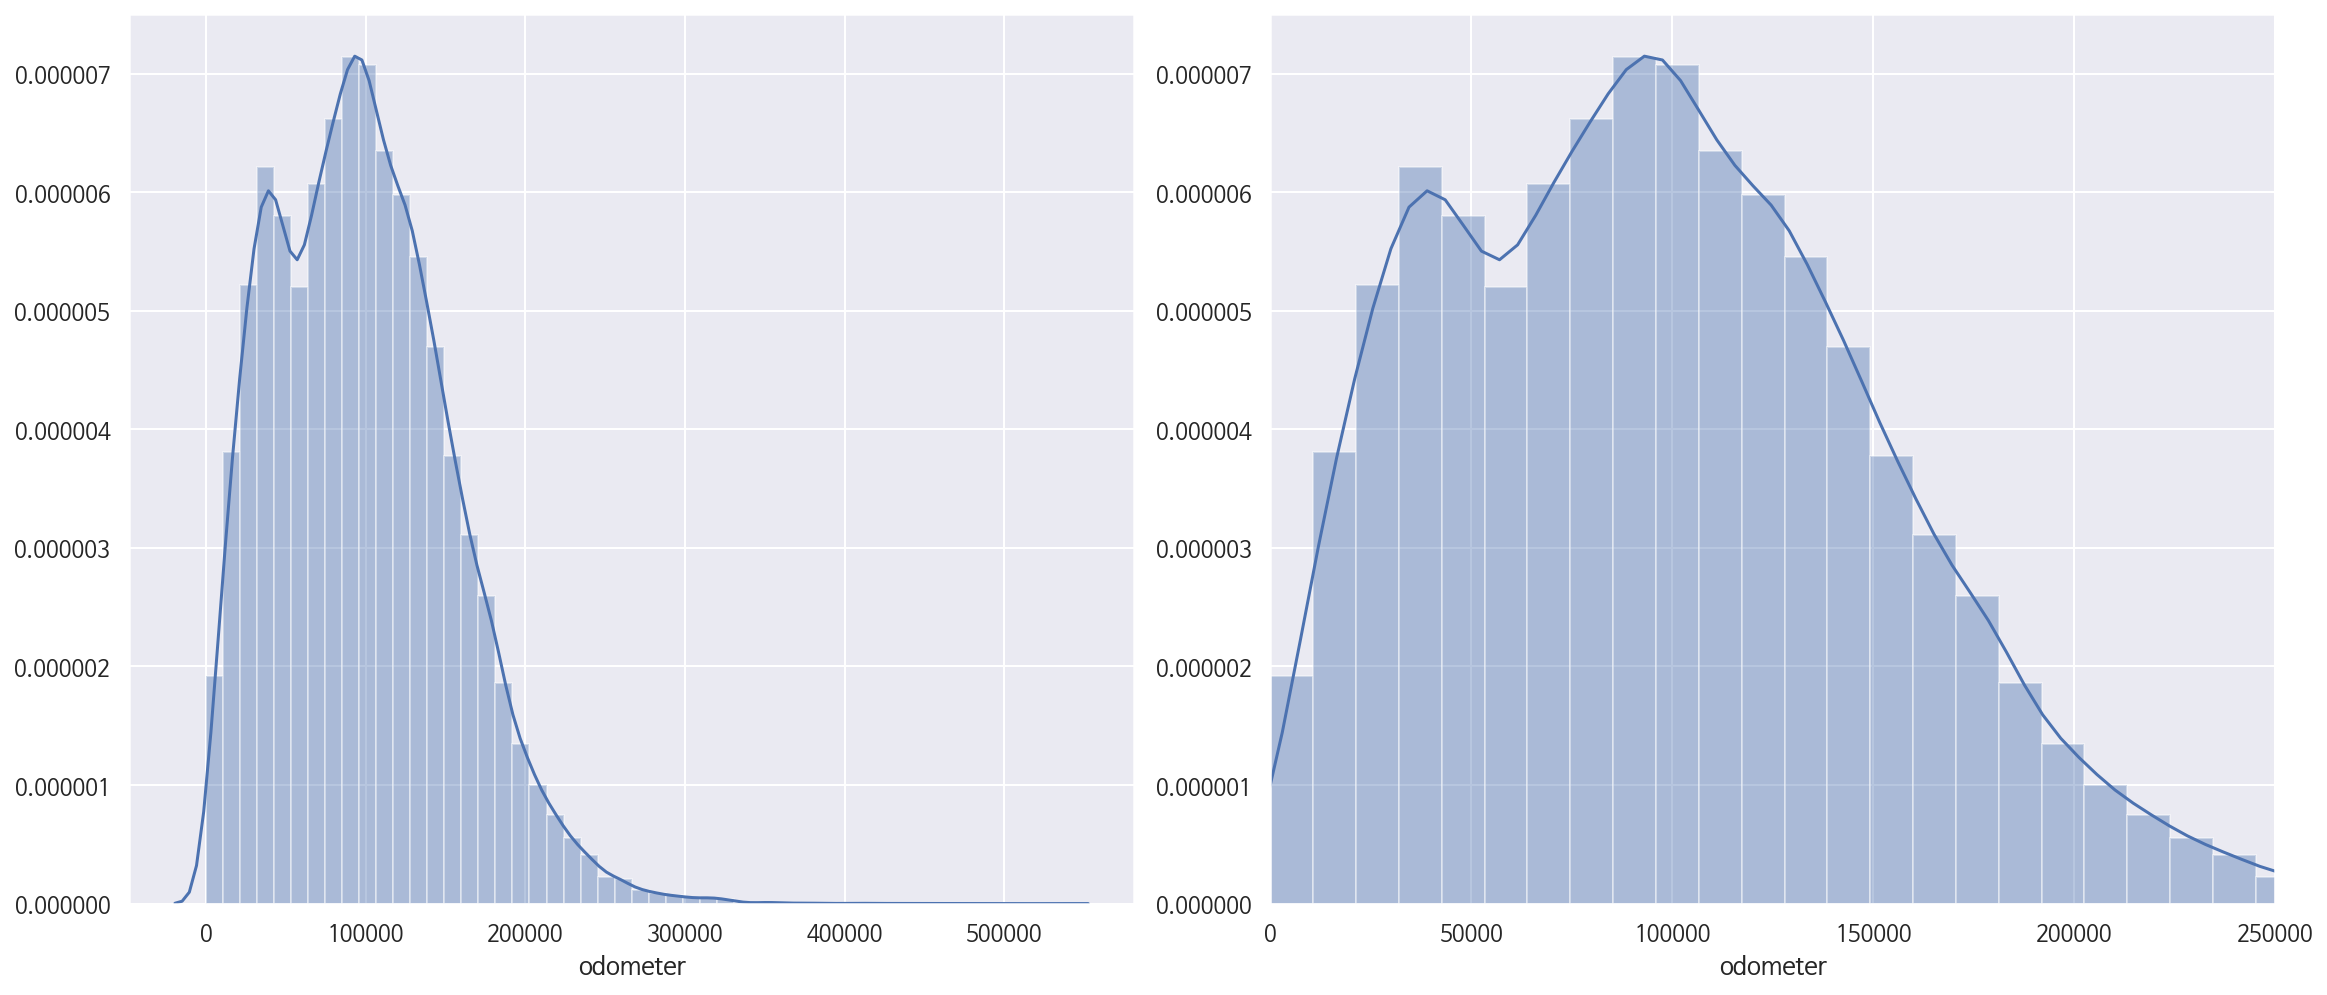

In [35]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.distplot(df['odometer'])
plt.subplot(122)
sns.distplot(df['odometer'])
plt.tight_layout()
plt.xlim(0,250000)
plt.show()

### 카테고리 독립변수 확인

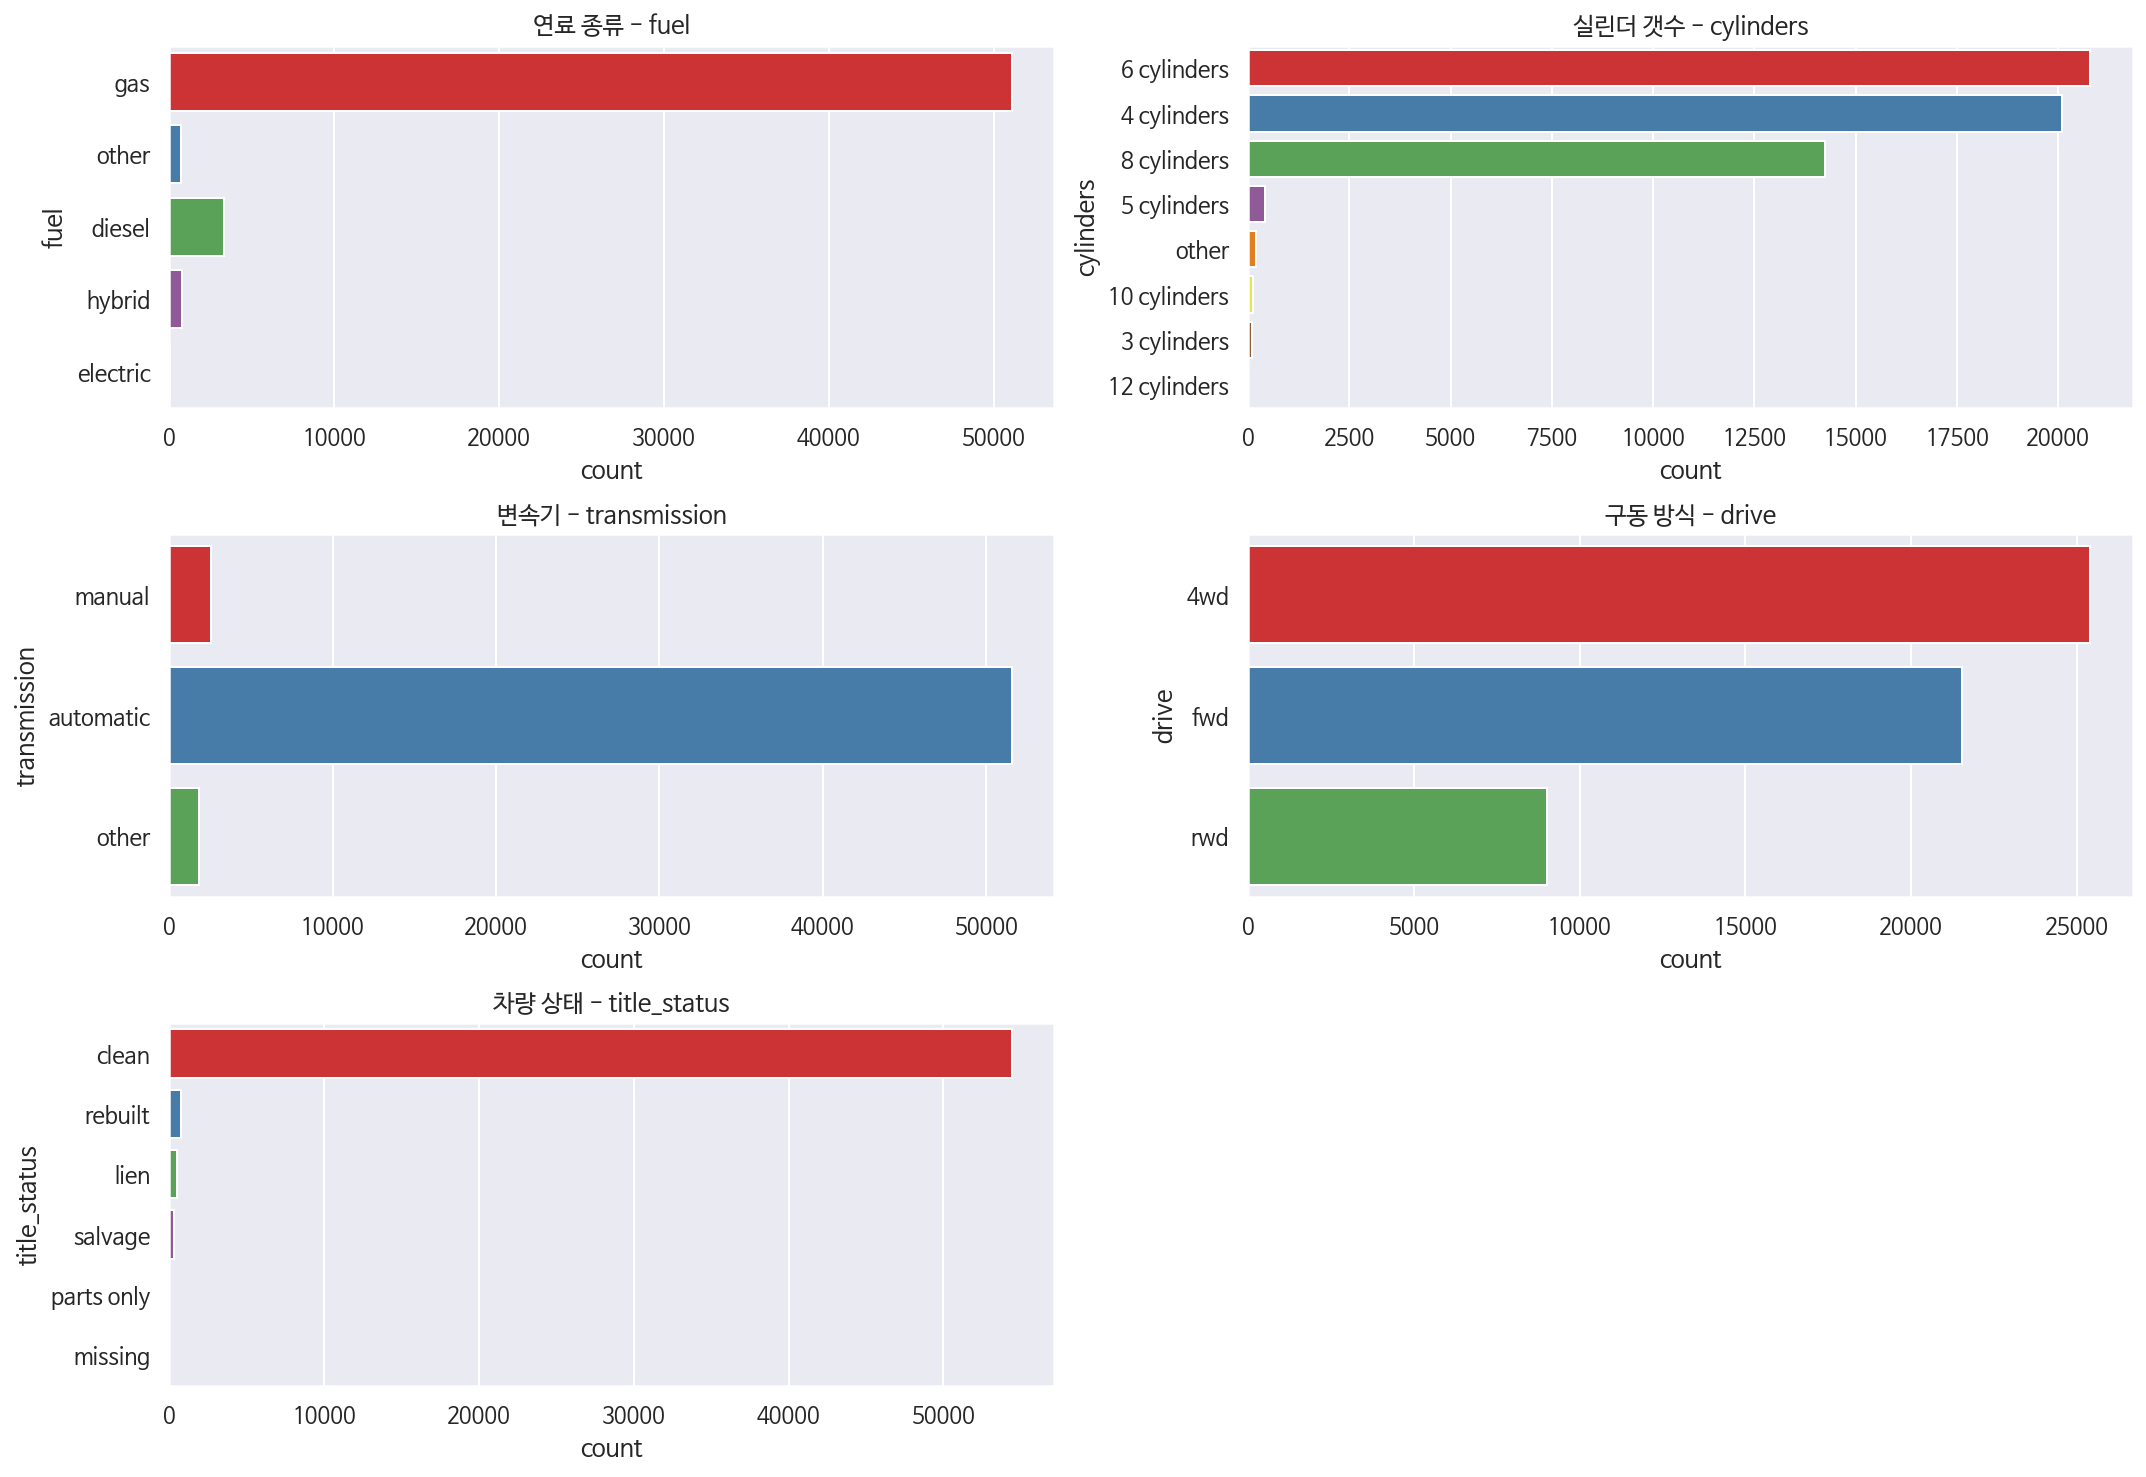

In [63]:
plt.figure(figsize=(15,20))
plt.subplot(621)
sns.countplot(
    data = df,
    y = "fuel",
    palette='Set1',
)
plt.title("연료 종류 - fuel")


plt.subplot(622)
sns.countplot(
    data = df,
    y = "cylinders",
    palette='Set1',
    order = df['cylinders'].value_counts().index

)
plt.title("실린더 갯수 - cylinders")


plt.subplot(623)
sns.countplot(
    data = df,
    y = "transmission",
    palette='Set1'
)
plt.title("변속기 - transmission")

plt.subplot(624)
sns.countplot(
    data = df,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식 - drive")


plt.subplot(625)
sns.countplot(
    data = df,
    y = "title_status",
    palette='Set1'
)
plt.title("차량 상태 - title_status")


plt.tight_layout()
plt.show()


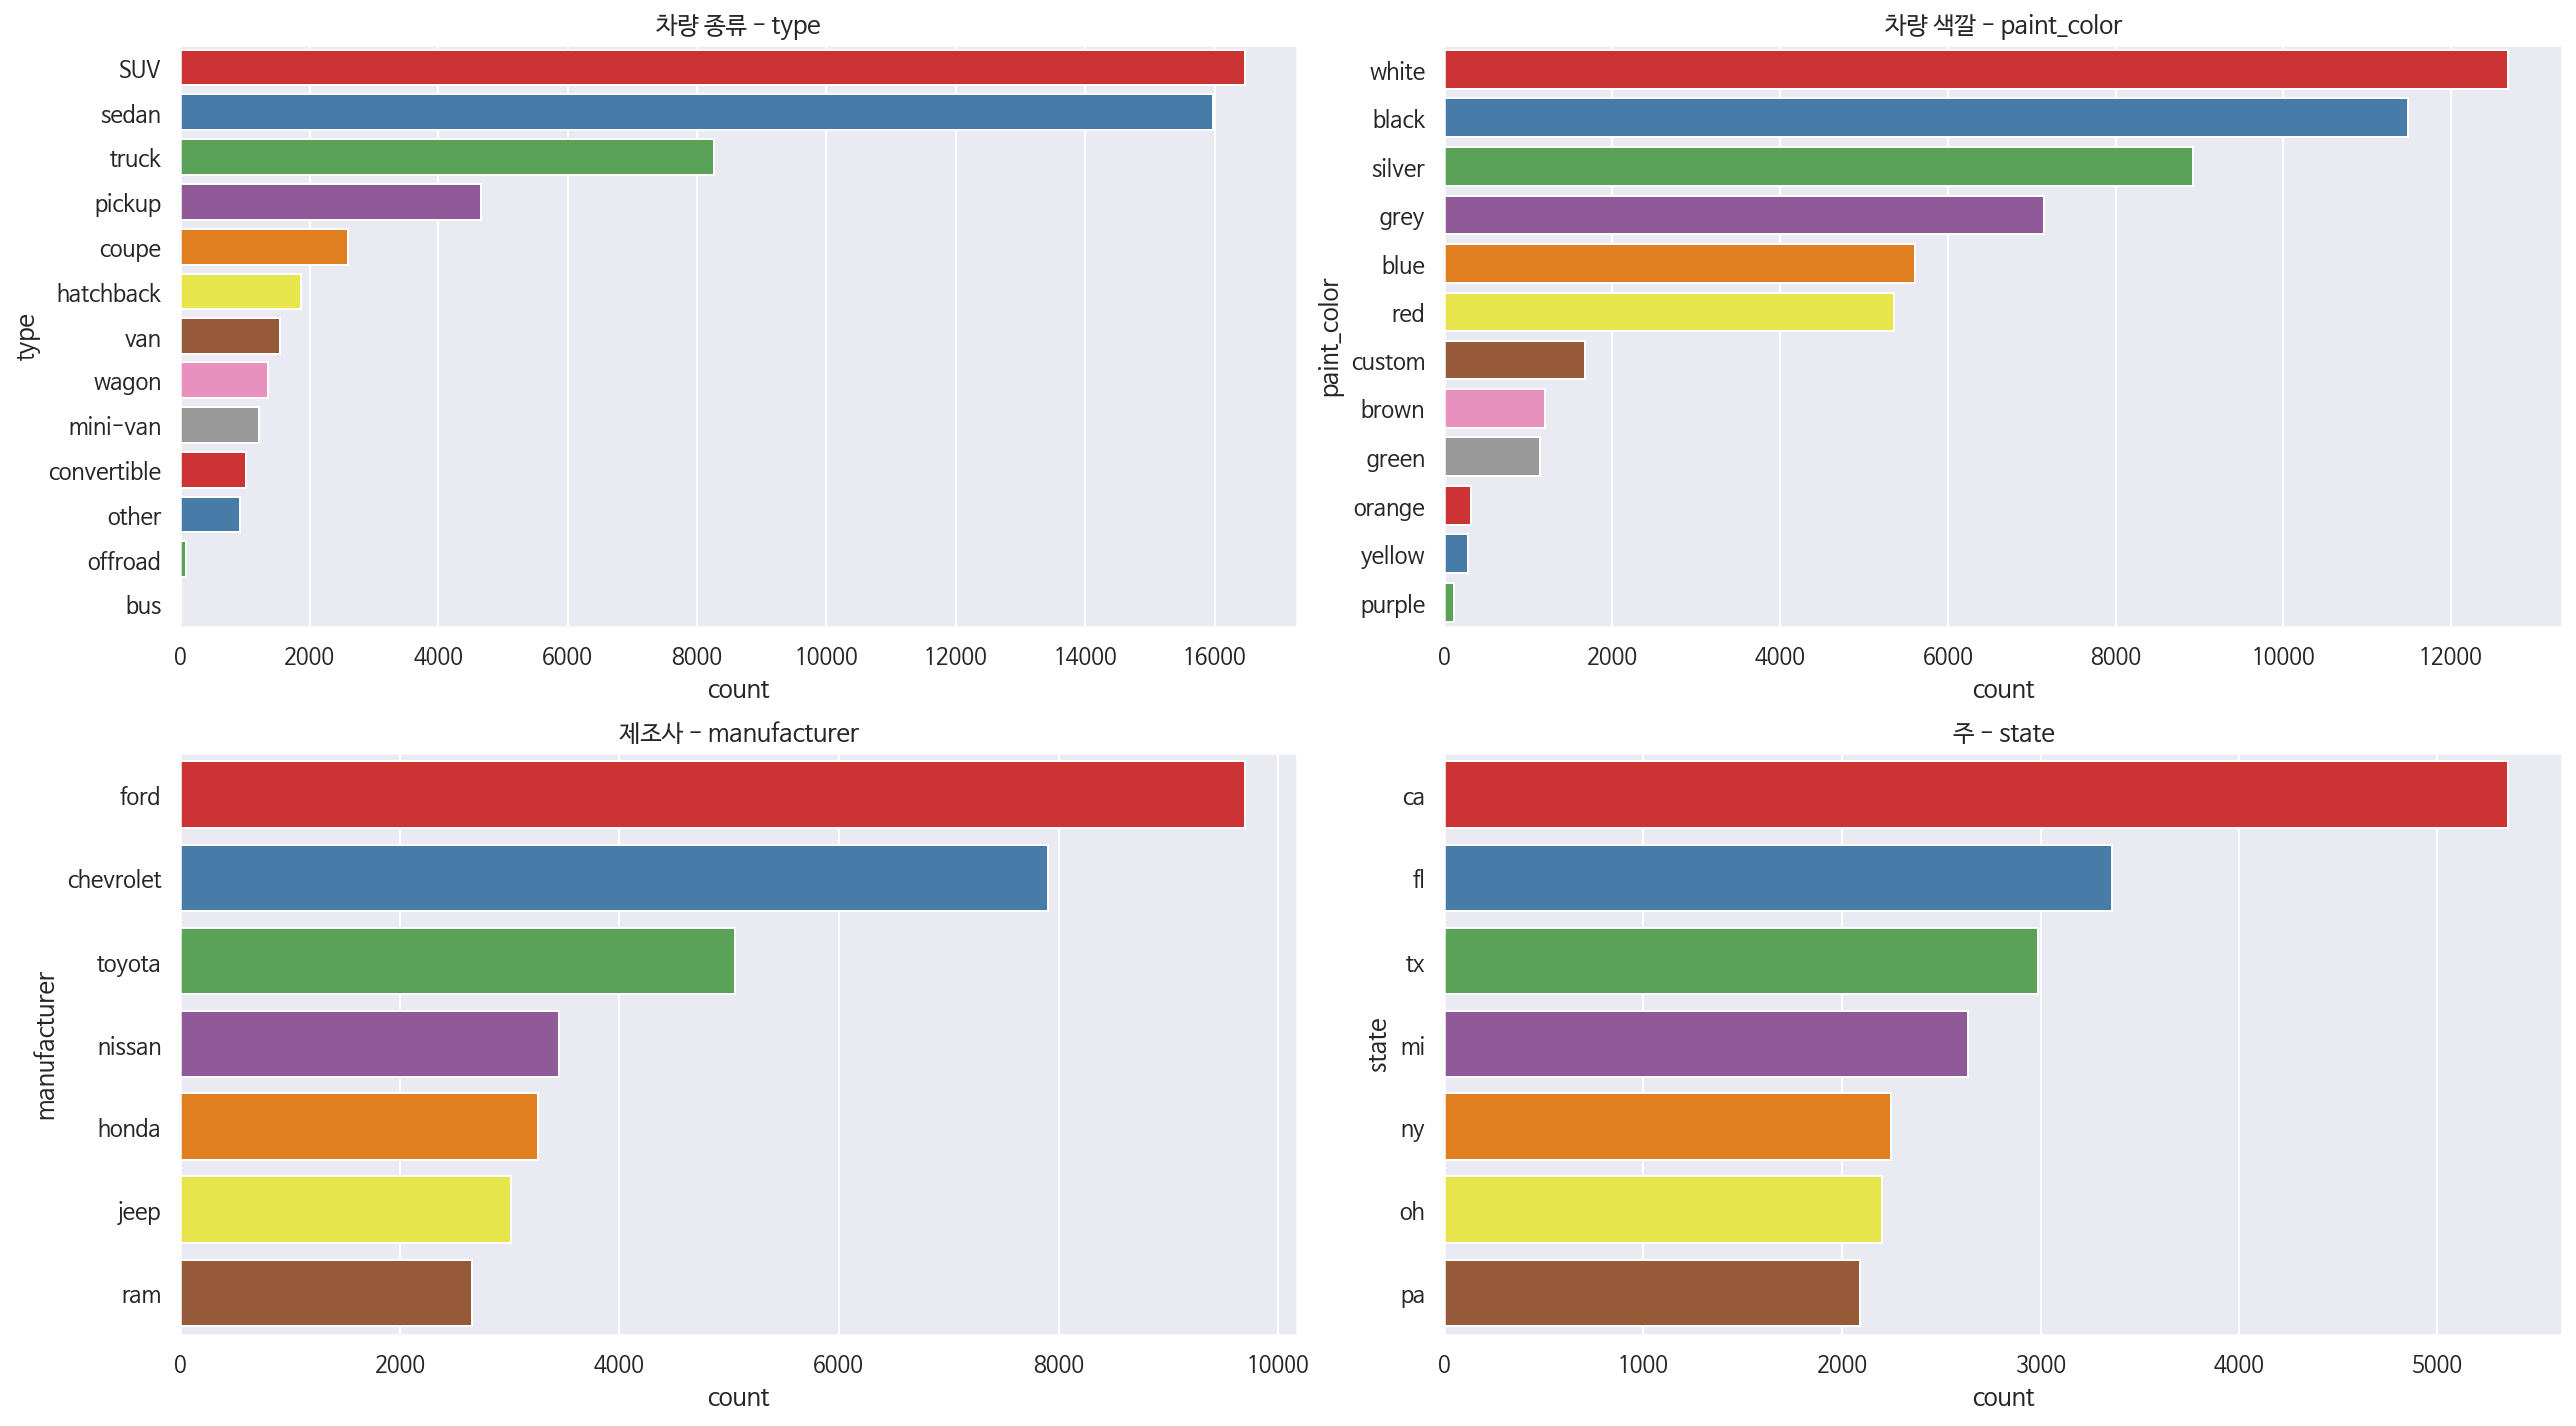

In [64]:
plt.figure(figsize=(18,10))

plt.subplot(221)
sns.countplot(
    data = df,
    y = "type",
    palette='Set1',
    order = df['type'].value_counts().index
)
plt.title("차량 종류 - type")


plt.subplot(222)
sns.countplot(
    data = df,
    y = "paint_color",
    palette='Set1',
    order = df['paint_color'].value_counts().index

)
plt.title("차량 색깔 - paint_color")

plt.subplot(223)
sns.countplot(
    data = df,
    y = "manufacturer",
    palette='Set1',
    order = df['manufacturer'].value_counts().iloc[:7].index,

)
plt.title("제조사 - manufacturer")

plt.subplot(224)
sns.countplot(
    data = df,
    y = "state",
    palette='Set1',
    order = df['state'].value_counts().iloc[:7].index
)
plt.title("주 - state")
plt.tight_layout()
plt.show()

##  변수 상관분석

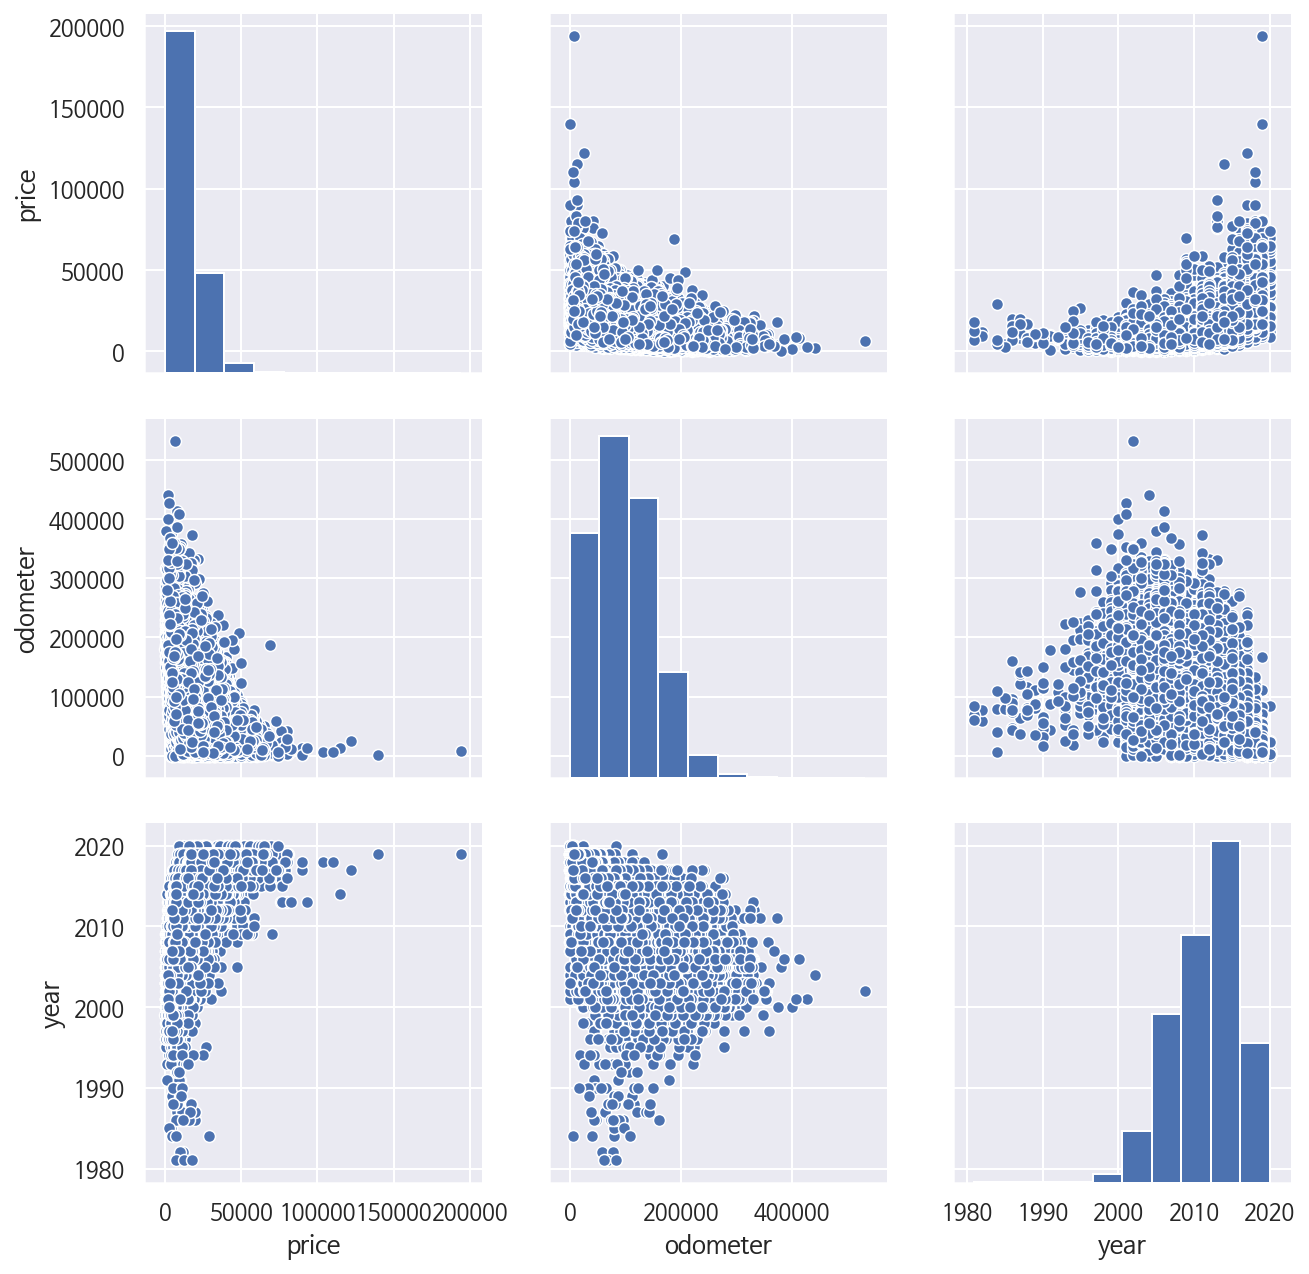

In [65]:
sns.pairplot(df[['price','odometer','year']],size=3)
plt.show()

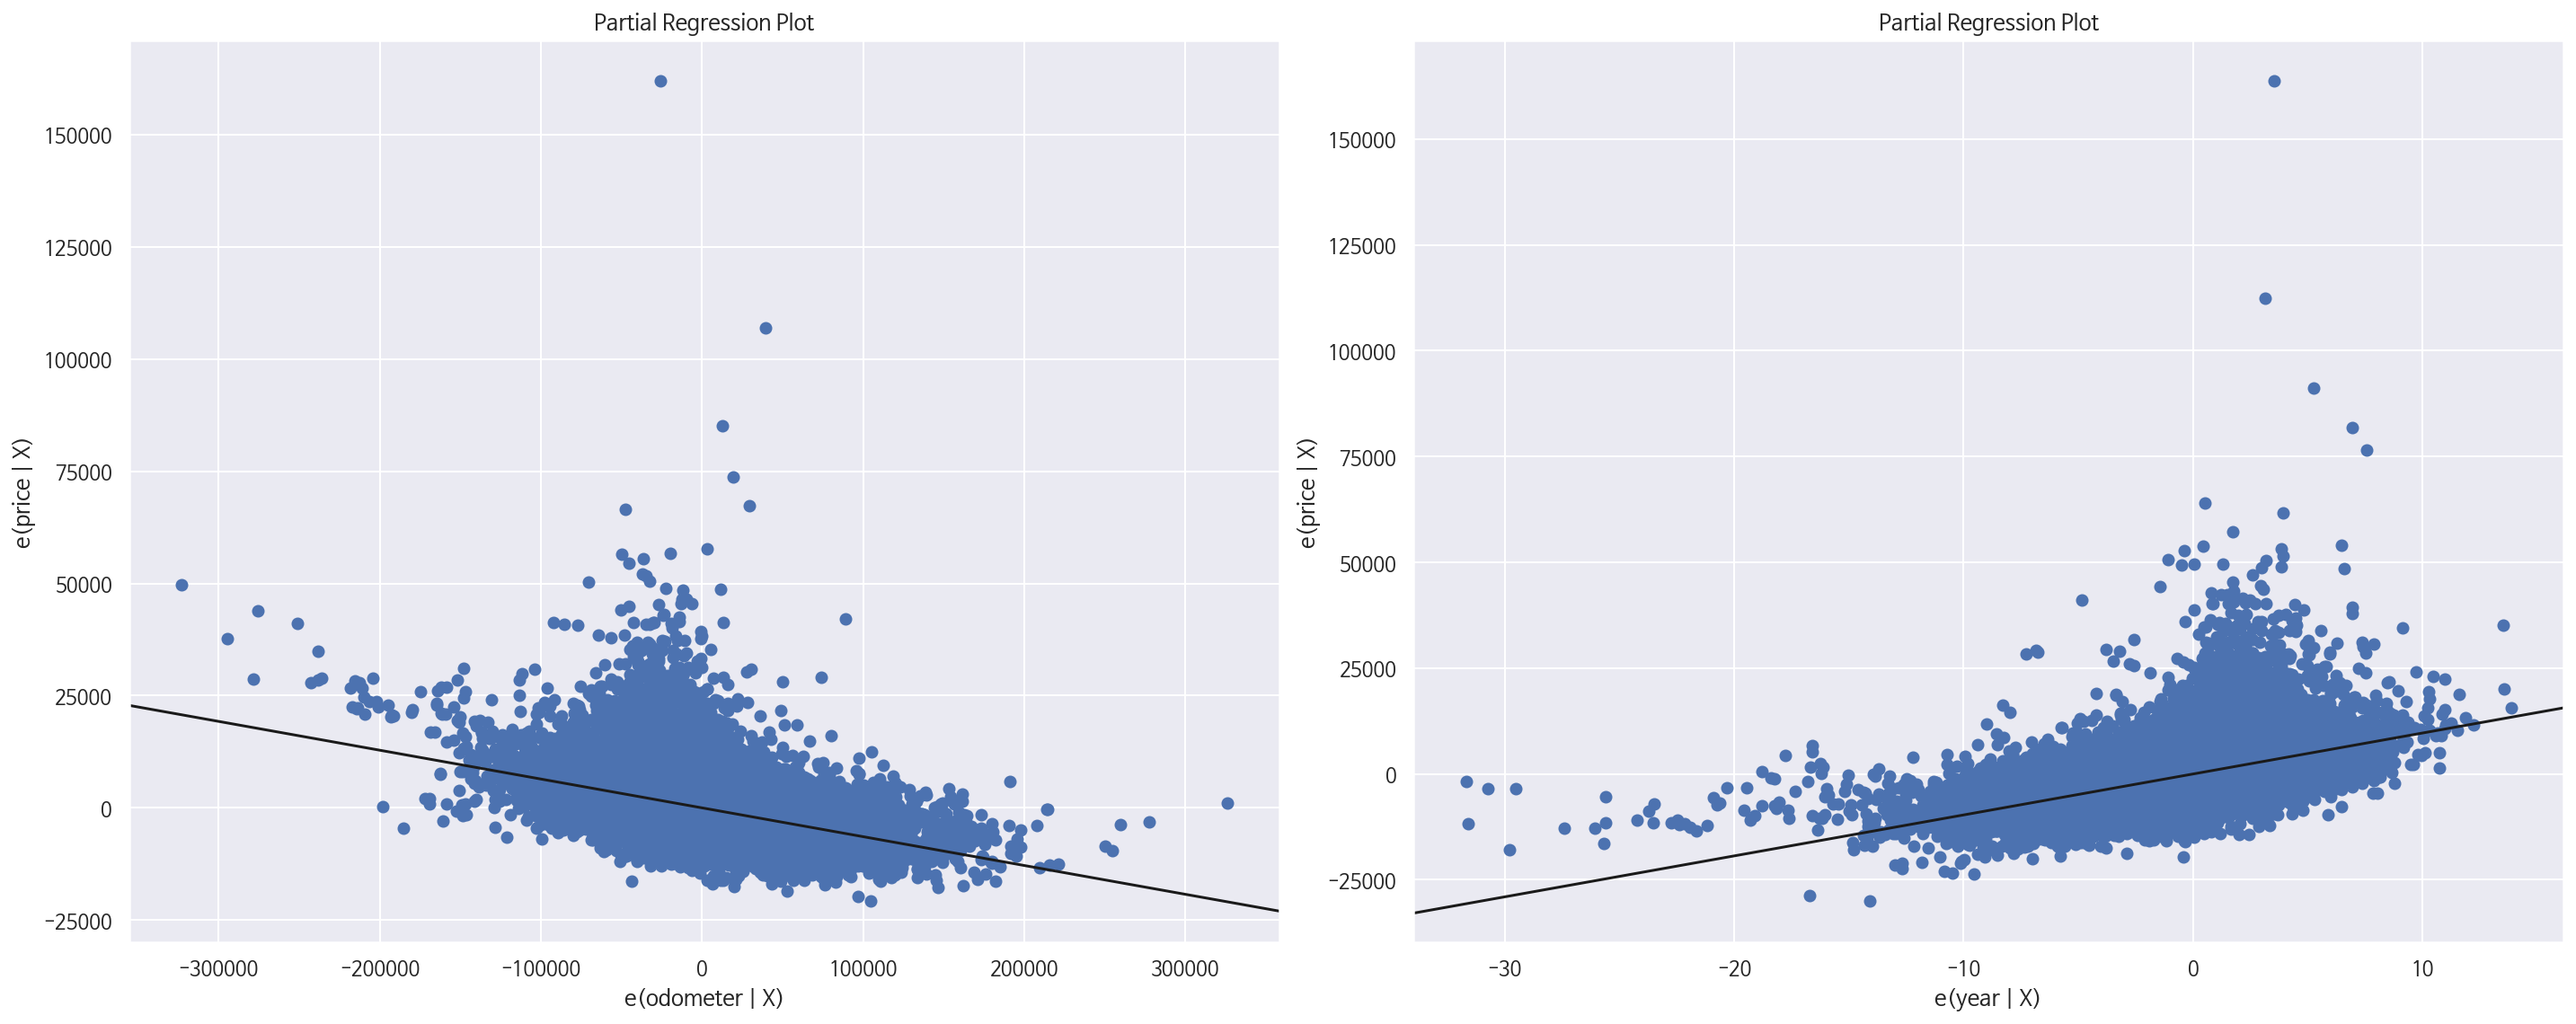

In [66]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


others = list(set(df.columns).difference(set(["price", "odometer"])))
p, resids = sm.graphics.plot_partregress(
    "price", "odometer", others, data=df, obs_labels=False, ret_coords=True, ax = ax1
)


others2 = list(set(df.columns).difference(set(["price", "year"])))
p, resids = sm.graphics.plot_partregress(
    "price", "year", others2, data=df, obs_labels=False, ret_coords=True, ax = ax2
)
plt.tight_layout()
plt.show()

# Train, Test 데이터 분할
- Train, Test 데이터 분할 및 k-fold 데이터 분할을 위한 카테고리 데이터 정리
- 2개 초과 10개 미만의 빈도를 가진 데이터를 삭제한 후  데이터를 분할한다.
- 분할할때 마다, 2개 초과 10개 미만의 빈도를 가진 데이터를 균등하게 분배한다.

### 카테고리 데이터 빈도수에 따른 필터링

In [1020]:
def value_counts_filter(num, columns):
    for column in columns:
        result = df[column].value_counts()[df[column].value_counts().sort_values() < num]
        if len(result) !=0:
            print(result.values.sum())
            print(result,end="\n\n===========\n\n")
            

In [1032]:
value_counts_filter(10,df.columns.difference(['price','odometer','year']))

2
12 cylinders    2
Name: cylinders, dtype: int64


26
tesla              9
alfa-romeo         7
harley-davidson    4
land rover         2
porche             2
aston-martin       1
ferrari            1
Name: manufacturer, dtype: int64


7
missing       4
parts only    3
Name: title_status, dtype: int64


4
bus    4
Name: type, dtype: int64




### 2개 초과 10개 미만 데이터 인덱스 확인

In [1033]:
def check_under_10_index(start_num,end_num,columns,df):
    test = {}
    test2 = []
    for column in columns:
        len_under_10 = len(df[column].value_counts()[(df[column].value_counts() < end_num) & (df[column].value_counts() > start_num)])
        if len_under_10:
            for i in range(len_under_10):
                index = df[df[column] == df[column].value_counts()[(df[column].value_counts() < end_num) & (df[column].value_counts() > start_num)].index[i]].index.values
                value = df[column].value_counts()[(df[column].value_counts() < end_num) & (df[column].value_counts() > start_num)].index[i]  
                test[value] = index
    test2.append(test)
    return test2

In [1034]:
index_df = pd.DataFrame(check_under_10_index(2,10, ['cylinders','manufacturer','title_status','type'],df))
index_df

,tesla,alfa-romeo,harley-davidson,missing,parts only,bus
0,"[1037, 1897, 12701, 12713, 13567, 13568, 15060...","[1931, 11481, 13715, 18035, 29591, 49763, 51630]","[7006, 34363, 52348, 52376]","[10963, 16194, 20106, 33971]","[9401, 9961, 29878]","[1336, 10320, 16975, 27573]"


### 데이터 분할에 사용할 인덱스 분류

In [1035]:
for_test_data = []
for_train_data_train = []
for_train_data_test = []
for column in index_df.columns:
    start = list(index_df[column][0])
    random.shuffle(start)
    if len(start) > 4:
        m = [start[i:i + 3] for i in range(0, len(start), 3)]
        for_test_data.append(m[0])
        for_train_data_train.append(m[1])
        for_train_data_test.append(m[2])
    elif len(start) == 4:
        m = [start[:2], start[2:3], start[3:]]
        for_test_data.append(m[0])
        for_train_data_train.append(m[1])
        for_train_data_test.append(m[2])
    else :
        m = [[i] for i in start]
        for_test_data.append(m[0])
        for_train_data_train.append(m[1])
        for_train_data_test.append(m[2])

### 10개 미만 데이터 우선 삭제 

In [1036]:
def delete_under_ten(df):
    for column in df.columns.difference(['id','price','odometer','year']):
        values = [value for value in df[column].value_counts()[df[column].value_counts() < 10].keys()]
        if values:
            for value in values:
                df = df[df[column] != value]
    return df

In [1037]:
df_deleted_under_ten = delete_under_ten(df)

### 2개 초과 0개 미만 데이터 균등 분배

In [1038]:
train_data, test_data = train_test_split(df_deleted_under_ten, test_size = .20, random_state = 7)
train_data = pd.concat([train_data, df.iloc[
    [element for array in for_train_data_train for element in array] + [element for array in for_train_data_test for element in array]
]],axis=0)
test_data = pd.concat([test_data,df.iloc[
    [element for array in for_test_data for element in array]]])
train_data.shape, test_data.shape

((44740, 12), (11194, 12))

# 모델링

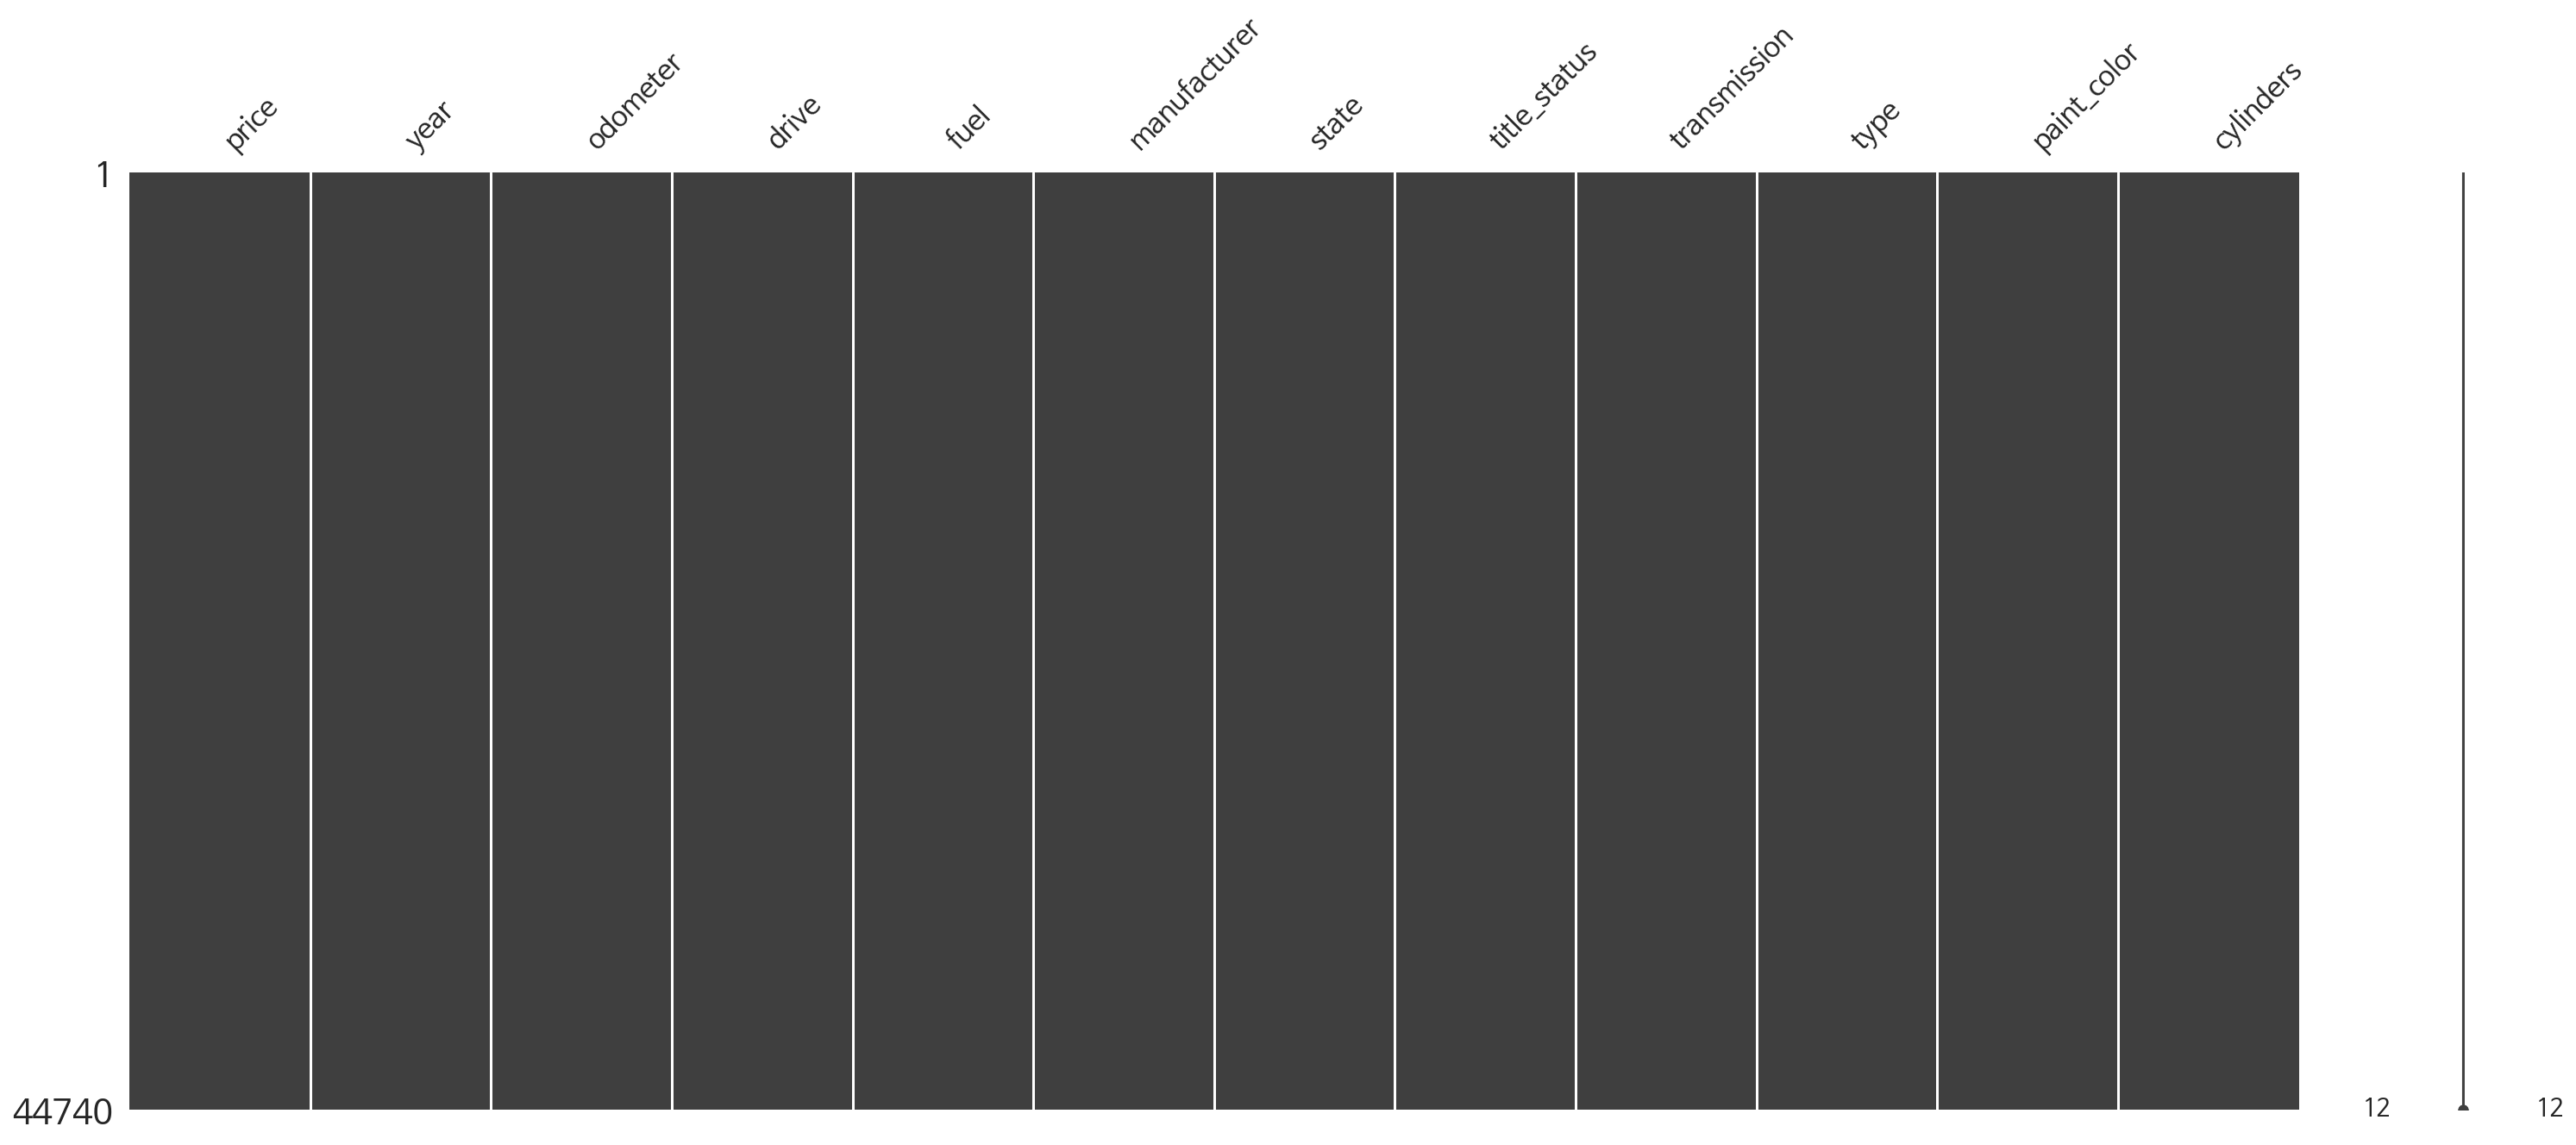

In [77]:
msno.matrix(train_data)
plt.show()

### LinearRegression
- train, test 데이터 분류
- test size : 0.2
- 종속변수인 가격에 log를 씌움

Test R2 score :  0.8572874252698142
RMSE of Train Data :  0.2578651334983411
RMSE of Test Data :  0.2583522725495928
K-fold :  [0.85718471 0.85962517 0.85600109 0.84637746 0.85515431 0.85641706
 0.85156626 0.8592392  0.85961022 0.85133019]


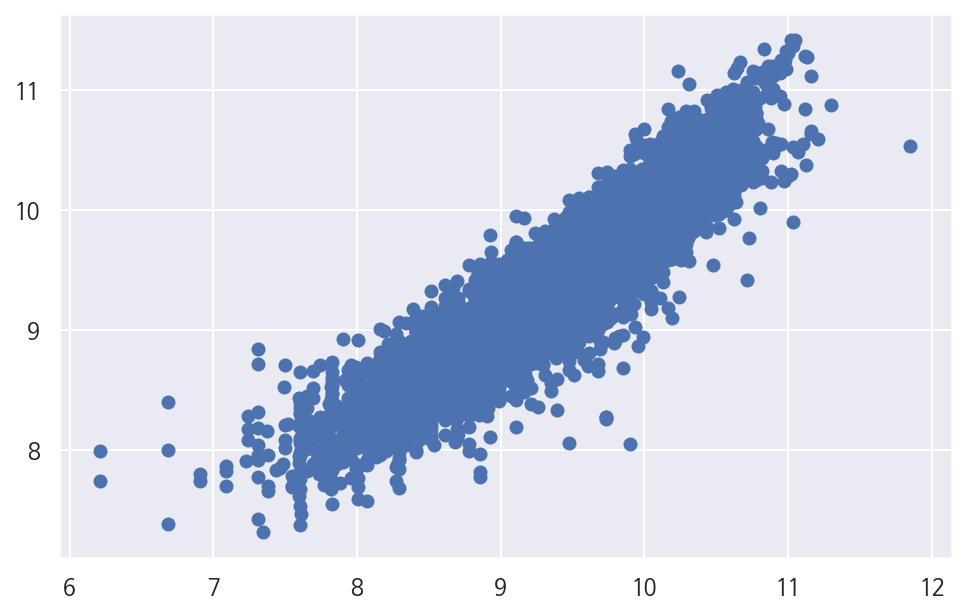

In [1071]:
X = train_data[train_data.columns.difference(['id_x','model','vin','price'])]
Y = np.log(train_data['price'])
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 0)

test_df = pd.concat([Y_train,X_train],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
r2 = r2_score(Y_test,predicted)
print('Test R2 score : ',r2)
plt.scatter(Y_test,predicted)


pred_tr = result.predict(X_train)
pred_test = result.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(Y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(Y_test, pred_test)))


# cv = KFold(10, shuffle=True, random_state=0)
model_0_cross_val_score = cross_val_score(model, X, Y, scoring=None, cv=10)

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)
print('K-fold : ', model_0_cross_val_score)

### sm.OLS.from_formula
- train, test 데이터 분류
- test size : 0.2
- 종속변수인 가격에 log를 씌움

### Model 1
- ```"np.log(price) ~ scale(odometer) + scale(year) + C(cylinders) + C(drive) + C(fuel) + C(manufacturer) + C(paint_color) + C(state) + C(title_status) + C(transmission) + C(type) + 0"```

In [31]:
from used_car_regression import UsedCarRegression
model = UsedCarRegression(df)

In [32]:
df.shape

(55942, 12)

In [33]:
formula = "np.log(price) ~ scale(odometer) + scale(year) + C(cylinders) + C(drive) + C(fuel) + C(manufacturer) + C(paint_color) + C(state) + C(title_status) + C(transmission) + C(type) + 0"

In [34]:
result, train_data, test_data = model.model_fit(formula,random_state=0)
print(result.summary())
pred = result.predict(test_data)

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     2062.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:47:38   Log-Likelihood:                -2846.7
No. Observations:               44732   AIC:                             5953.
Df Residuals:                   44602   BIC:                             7086.
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(cy

### R2 score 확인

In [35]:
r2_score(np.log(test_data['price']),pred)

0.8548698092704324

### 교차 검증

In [36]:
cross_validation_model1 = model.cross_validation(formula,1,10)
cross_validation_model1

[0.8520929931440752,
 0.8479951773132202,
 0.8527394199098047,
 0.8522128257138989,
 0.8513946853919533,
 0.8517446270422746,
 0.8519015459747948,
 0.8526593081018188,
 0.8509449369727766,
 0.8505238132704278]

### Model 1
- ```"np.log(price) ~ scale(odometer) + scale(year) + C(cylinders) + C(drive) + C(fuel) + C(manufacturer) + C(paint_color) + C(state) + C(title_status) + C(transmission) + C(type) + 0"```

### Model 2
- ```"np.log(price) ~ scale(odometer) + scale(year) + C(fuel) + C(paint_color) + C(state) + C(title_status) + C(transmission) + C(cylinders) : C(manufacturer) + C(type) : C(drive) + 0""```

# ANOVA를 통한 독립변수 점검

In [1099]:
anova = sm.stats.anova_lm(result, typ=2)
anova.sort_values(by=['F'],ascending=False)

,sum_sq,df,F,PR(>F)
C(cylinders),23162.69213,7.00000,49616.26897,0.00000
scale(year),2242.60336,1.00000,33626.80272,0.00000
scale(odometer),1362.30015,1.00000,20427.06221,0.00000
C(fuel),548.16605,4.00000,2054.87425,0.00000
C(drive),209.18157,2.00000,1568.29059,0.00000
C(type),226.65556,12.00000,283.21630,0.00000
C(manufacturer),491.81660,35.00000,210.70180,0.00000
C(transmission),24.72455,2.00000,185.36662,0.00000
C(title_status),27.30245,5.00000,81.87753,0.00000
C(state),108.95063,50.00000,32.67329,0.00000


# Interaction 설명 추가

### Cylinders 와 Manufacturer 의 관계
- 각 제조사별 주력 차종 상이
- 차종별 Cylinder(배기량)이 다름

### Type과 Drive의 관계
- SUV, 세단, 경차등으로 분류 할때 각각 다른 구동방식(4WD, FWD, RWD 등)을 가지고 있음

In [1108]:
formula = "np.log(price) ~ scale(odometer) + scale(year) + cylinders:manufacturer + fuel+ paint_color + state + title_status + transmission+type:drive"

In [1109]:
result, train_data, test_data = model.model_fit(formula)
print(result.summary())
pred = result.predict(test_data)
r2_score(np.log(test_data['price']),pred)

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1150.
Date:                Thu, 09 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:42:00   Log-Likelihood:                -452.81
No. Observations:               44732   AIC:                             1430.
Df Residuals:                   44470   BIC:                             3711.
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

0.8679593900809351

### 교차 검증

In [1110]:
cross_validation_model2 = model.cross_validation(formula,0,10)
cross_validation_model2

[0.8685039001675037,
 0.8646977996842958,
 0.8631718764480292,
 0.8698501430785603,
 0.8608323008740095,
 0.8625680545373073,
 0.8578661442862828,
 0.8693182073961702,
 0.8637448913156024,
 0.8672030671753775]

# k-fold 검증 성능 비교
- 과최적화를 막기 위한 방안

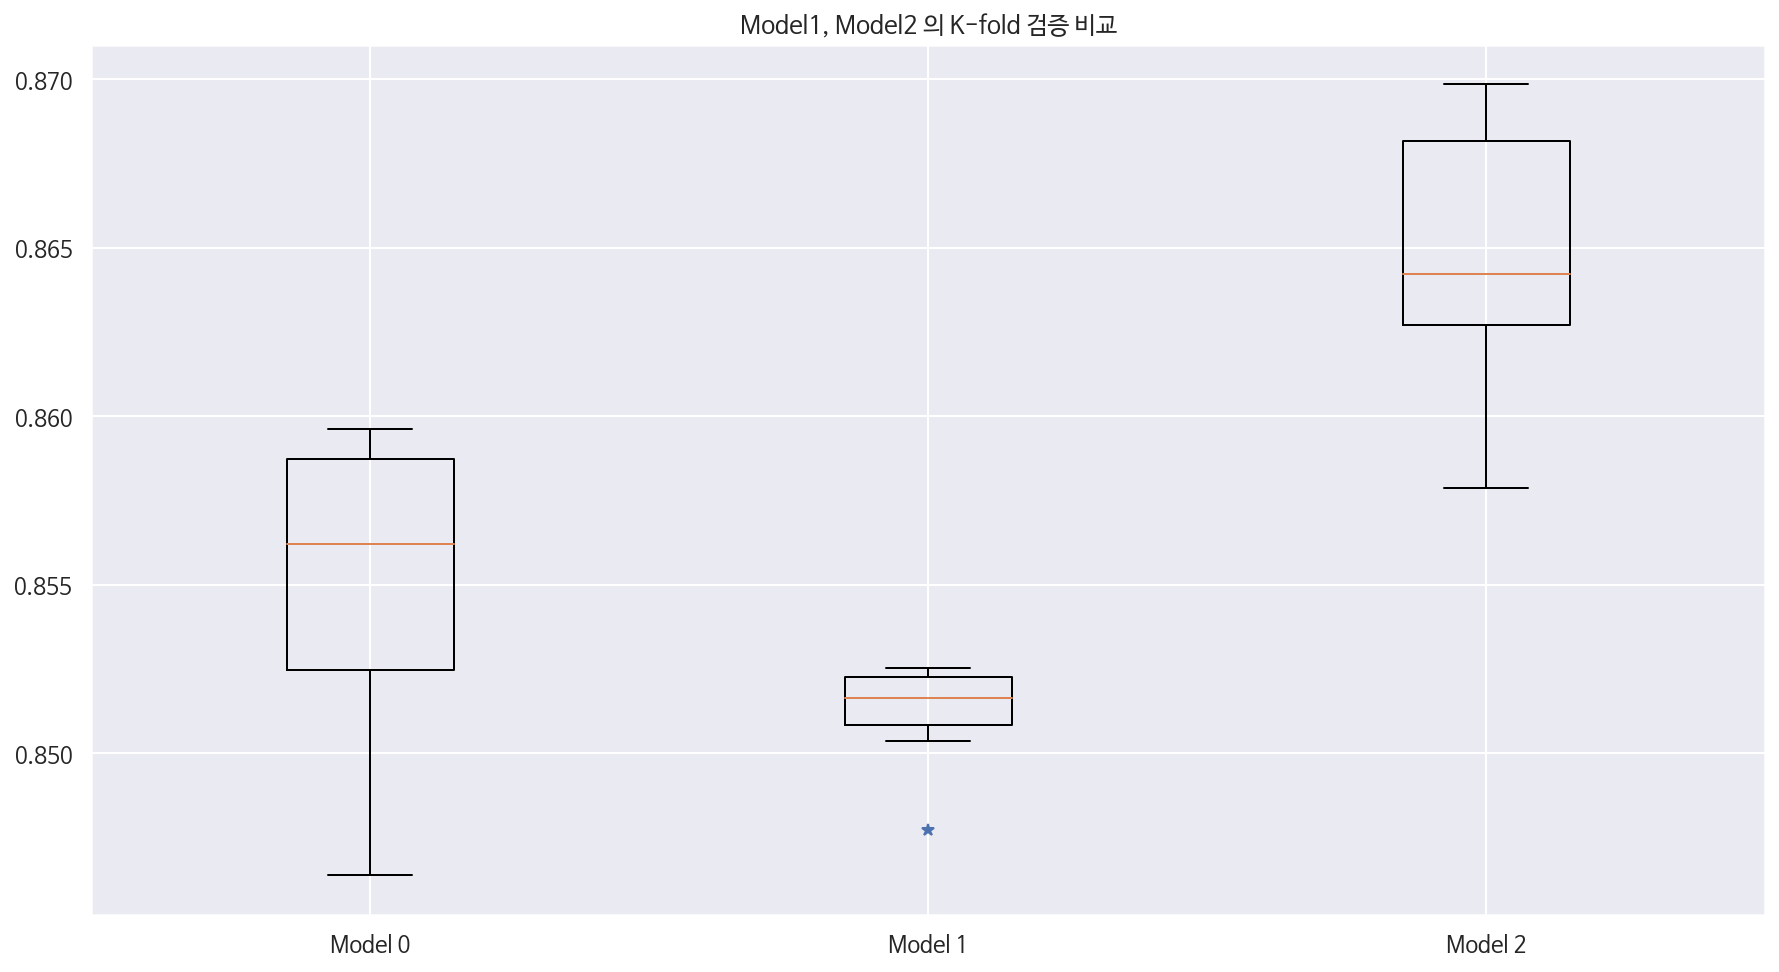

In [1111]:
fig, ax = plt.subplots(figsize=(15,8))

ax.boxplot([model_0_cross_val_score,cross_validation_model1, cross_validation_model2], sym="b*", labels=['Model 0','Model 1', 'Model 2'],)
plt.title('Model1, Model2 의 K-fold 검증 비교')
plt.show()

# 각 모델별 Test 데이터로 예측한 R-sqaure

In [101]:
formula = "np.log(price) ~ scale(odometer) + scale(year) + C(cylinders) + C(drive) + C(fuel) + C(manufacturer) + C(paint_color) + C(state) + C(title_status) + C(transmission) + C(type)"

In [102]:
result, train_data, test_data = model.model_fit(formula, random_state=8)
prediction = result.predict(test_data[test_data.columns.difference(['price'])])
print("Model 1 R-sqaure : ", r2_score(np.log(test_data['price']),prediction))

Model 1 R-sqaure :  0.8572284360114472


In [103]:
formula = "np.log(price) ~ scale(odometer) + scale(year) + C(cylinders) + C(drive) + C(fuel) + C(manufacturer) + C(paint_color) + C(state) + C(title_status) + C(transmission) + C(type) + scale(year):C(cylinders) + scale(odometer): C(fuel) + scale(year):C(fuel) + scale(odometer): C(drive) + scale(year):C(drive)"

In [104]:
result, train_data, test_data = model.model_fit(formula, random_state=8)
prediction = result.predict(test_data[test_data.columns.difference(['price'])])
print("Model 1 R-sqaure : ", r2_score(np.log(test_data['price']),prediction))

Model 1 R-sqaure :  0.866872907805365


# 가설

### 가설 1번
- 주행거리 5만킬로 미터 이하일때 파는게 좋을것이다.

In [37]:
hypothesis_1 = sigma_2_df['vehicle'].value_counts()

In [38]:
hypothesis_1[:10]

2012 Ford F-150 FX4                 134
2014 Chevrolet Silverado 1500 LT    131
2010 Ford F-150 XL                  125
2011 Chevrolet Silverado 1500 LT    115
2016 Chevrolet Silverado 1500 LT    112
2016 Ford F-150 Lariat              111
2013 Ford F-150 XL                  111
2013 Ford F-150 FX4                 110
2013 Chevrolet Silverado 1500 LT    108
2015 Chevrolet Silverado 1500 LT    107
Name: vehicle, dtype: int64

In [577]:
ls = list(map(lambda x: " ".join(x.split(' ')[1:5]), sigma_2_df['vehicle'] ))

In [39]:
data = sigma_2_df[sigma_2_df['vehicle'] == "2012 Ford F-150 FX4"]
data = data[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

In [53]:
data2 = sigma_2_df[sigma_2_df['vehicle'] == "2014 Chevrolet Silverado 1500 LT"]
data2 = data2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

In [40]:
data.shape

(134, 12)

In [41]:
# odometer 외의 컬럼은 다 최빈값으로 채운다

In [56]:
def hypothesis_proof(df):
   
    for column in df.columns.difference(['price','odometer']):
        df[column] = df[column].value_counts().keys()[0]

    df['odometer'] = range(0,len(df)*1000,1000)
    df.reset_index(drop=True)
    

    return np.exp(result.predict(df)), df

In [46]:
hypothesis_1 = np.exp(result.predict(data))

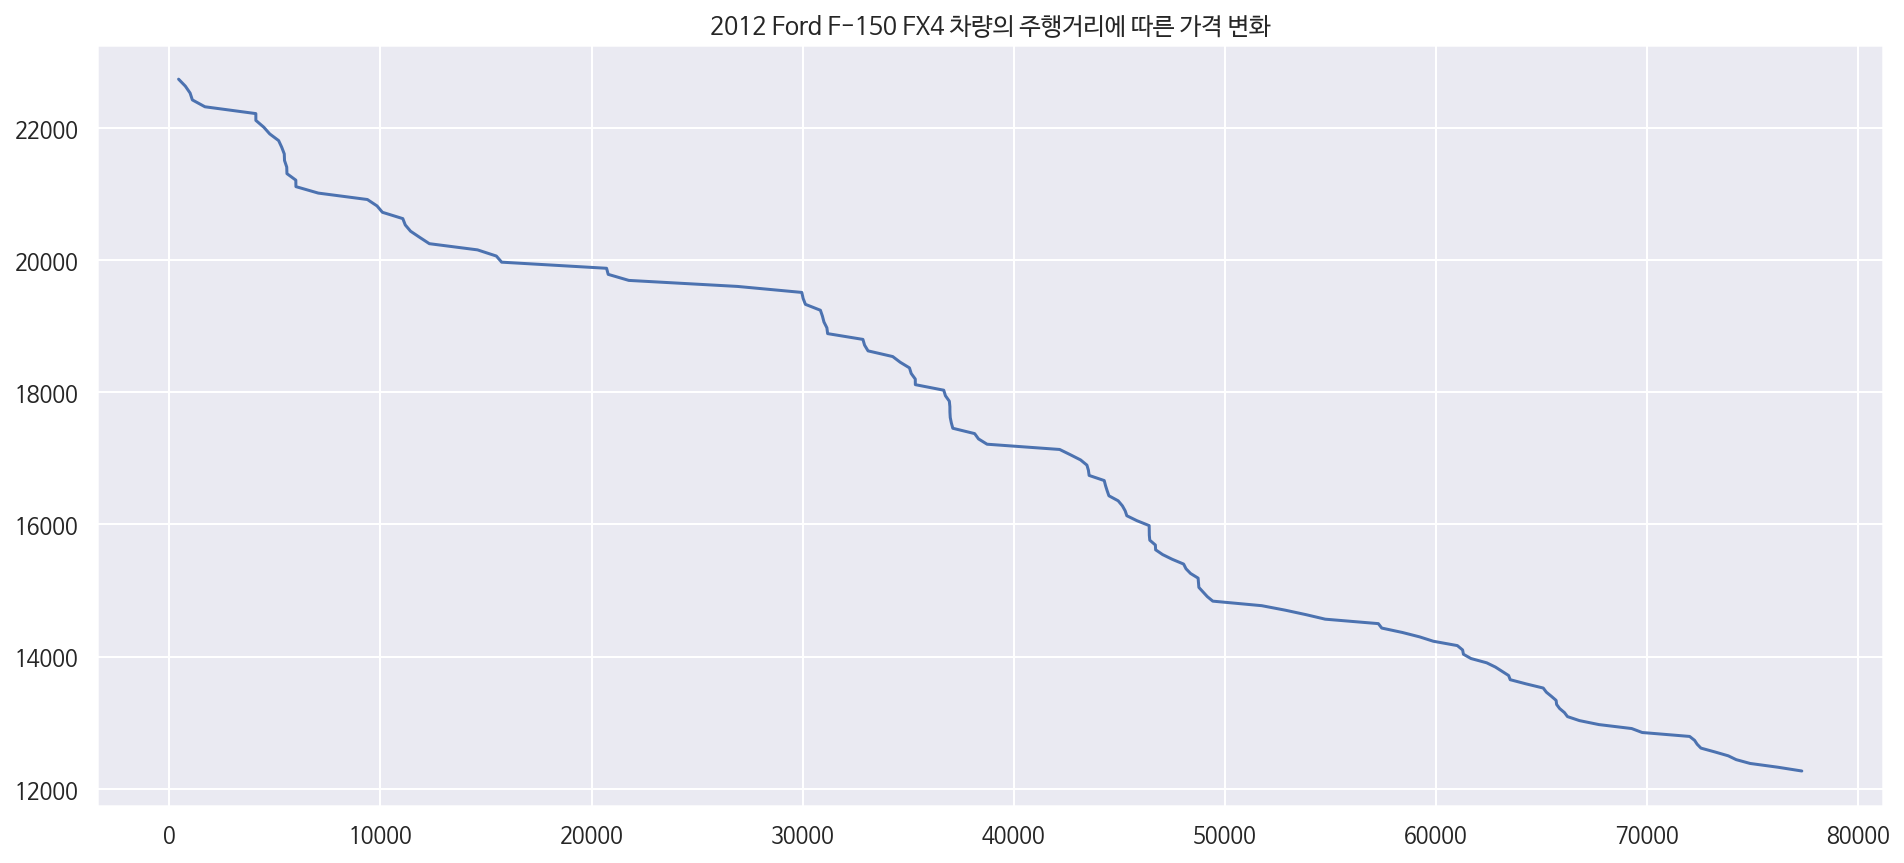

In [52]:
plt.figure(figsize=(16,7))
plt.plot(hypothesis_1)
plt.title("2012 Ford F-150 FX4 차량의 주행거리에 따른 가격 변화")
plt.show()

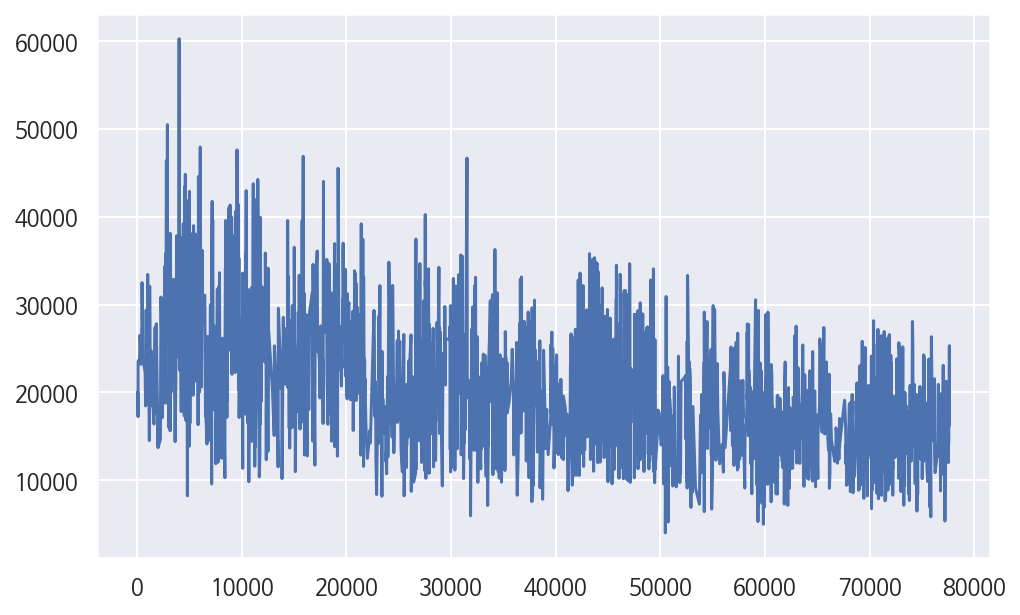

In [501]:
plt.plot(a)

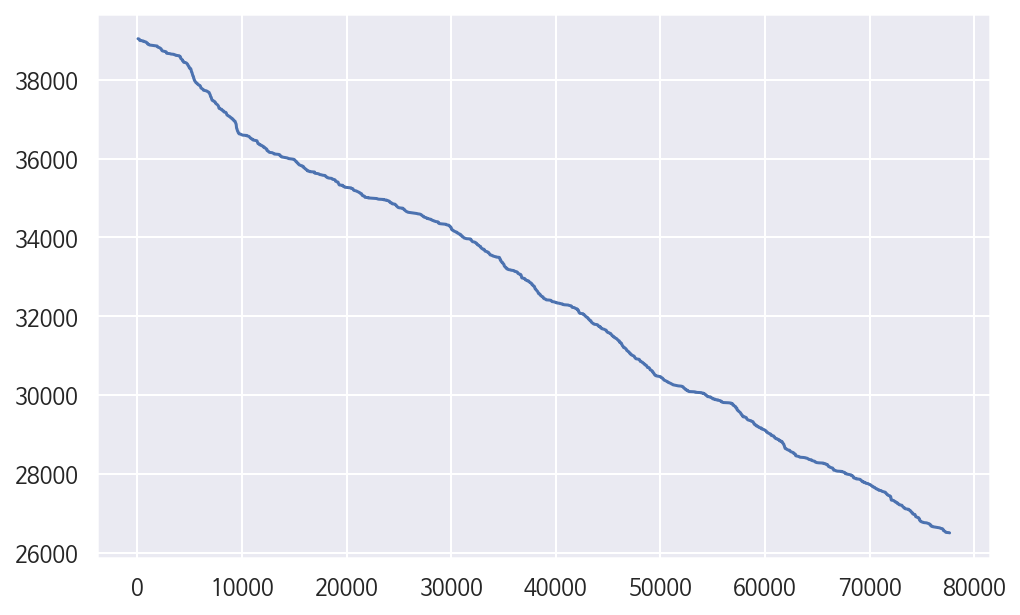

In [585]:
# 같은 트림의 모델(연식 = 최빈값)으로 했을때 F-150모델의 가격 변화
plt.plot(a)

## 가설 2
- 지역별 가격차이가 있을 것이다

In [802]:
def hypothesis_proof2(df):
   
    for column in df.columns.difference(['price','state','odometer']):
        df[column] = df[column].value_counts().keys()[0]

    df.reset_index(drop=True)
    

    return df

In [1006]:
Ford_f_150 = sigma_2_df[sigma_2_df['vehicle'] == "2012 Ford F-150 FX4"]
Ford_f_150 = Ford_f_150[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

Ford_f_150 = Ford_f_150.groupby(['state']).agg('mean')['price']
Ford_f_150 = Ford_f_150.sort_values(ascending=False)

In [1009]:
Chevrolet_Silverado = sigma_2_df[sigma_2_df['vehicle'] == "2014 Chevrolet Silverado 1500 LT"]
Chevrolet_Silverado = Chevrolet_Silverado[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

Chevrolet_Silverado = Chevrolet_Silverado.groupby(['state']).agg('mean')['price']
Chevrolet_Silverado = Chevrolet_Silverado.sort_values(ascending=False)

In [1015]:
test=sigma_2_df[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
print(test.shape)
test = test.groupby(['state']).agg('mean')['price']
test = test.sort_values(ascending=False)

(55942, 12)


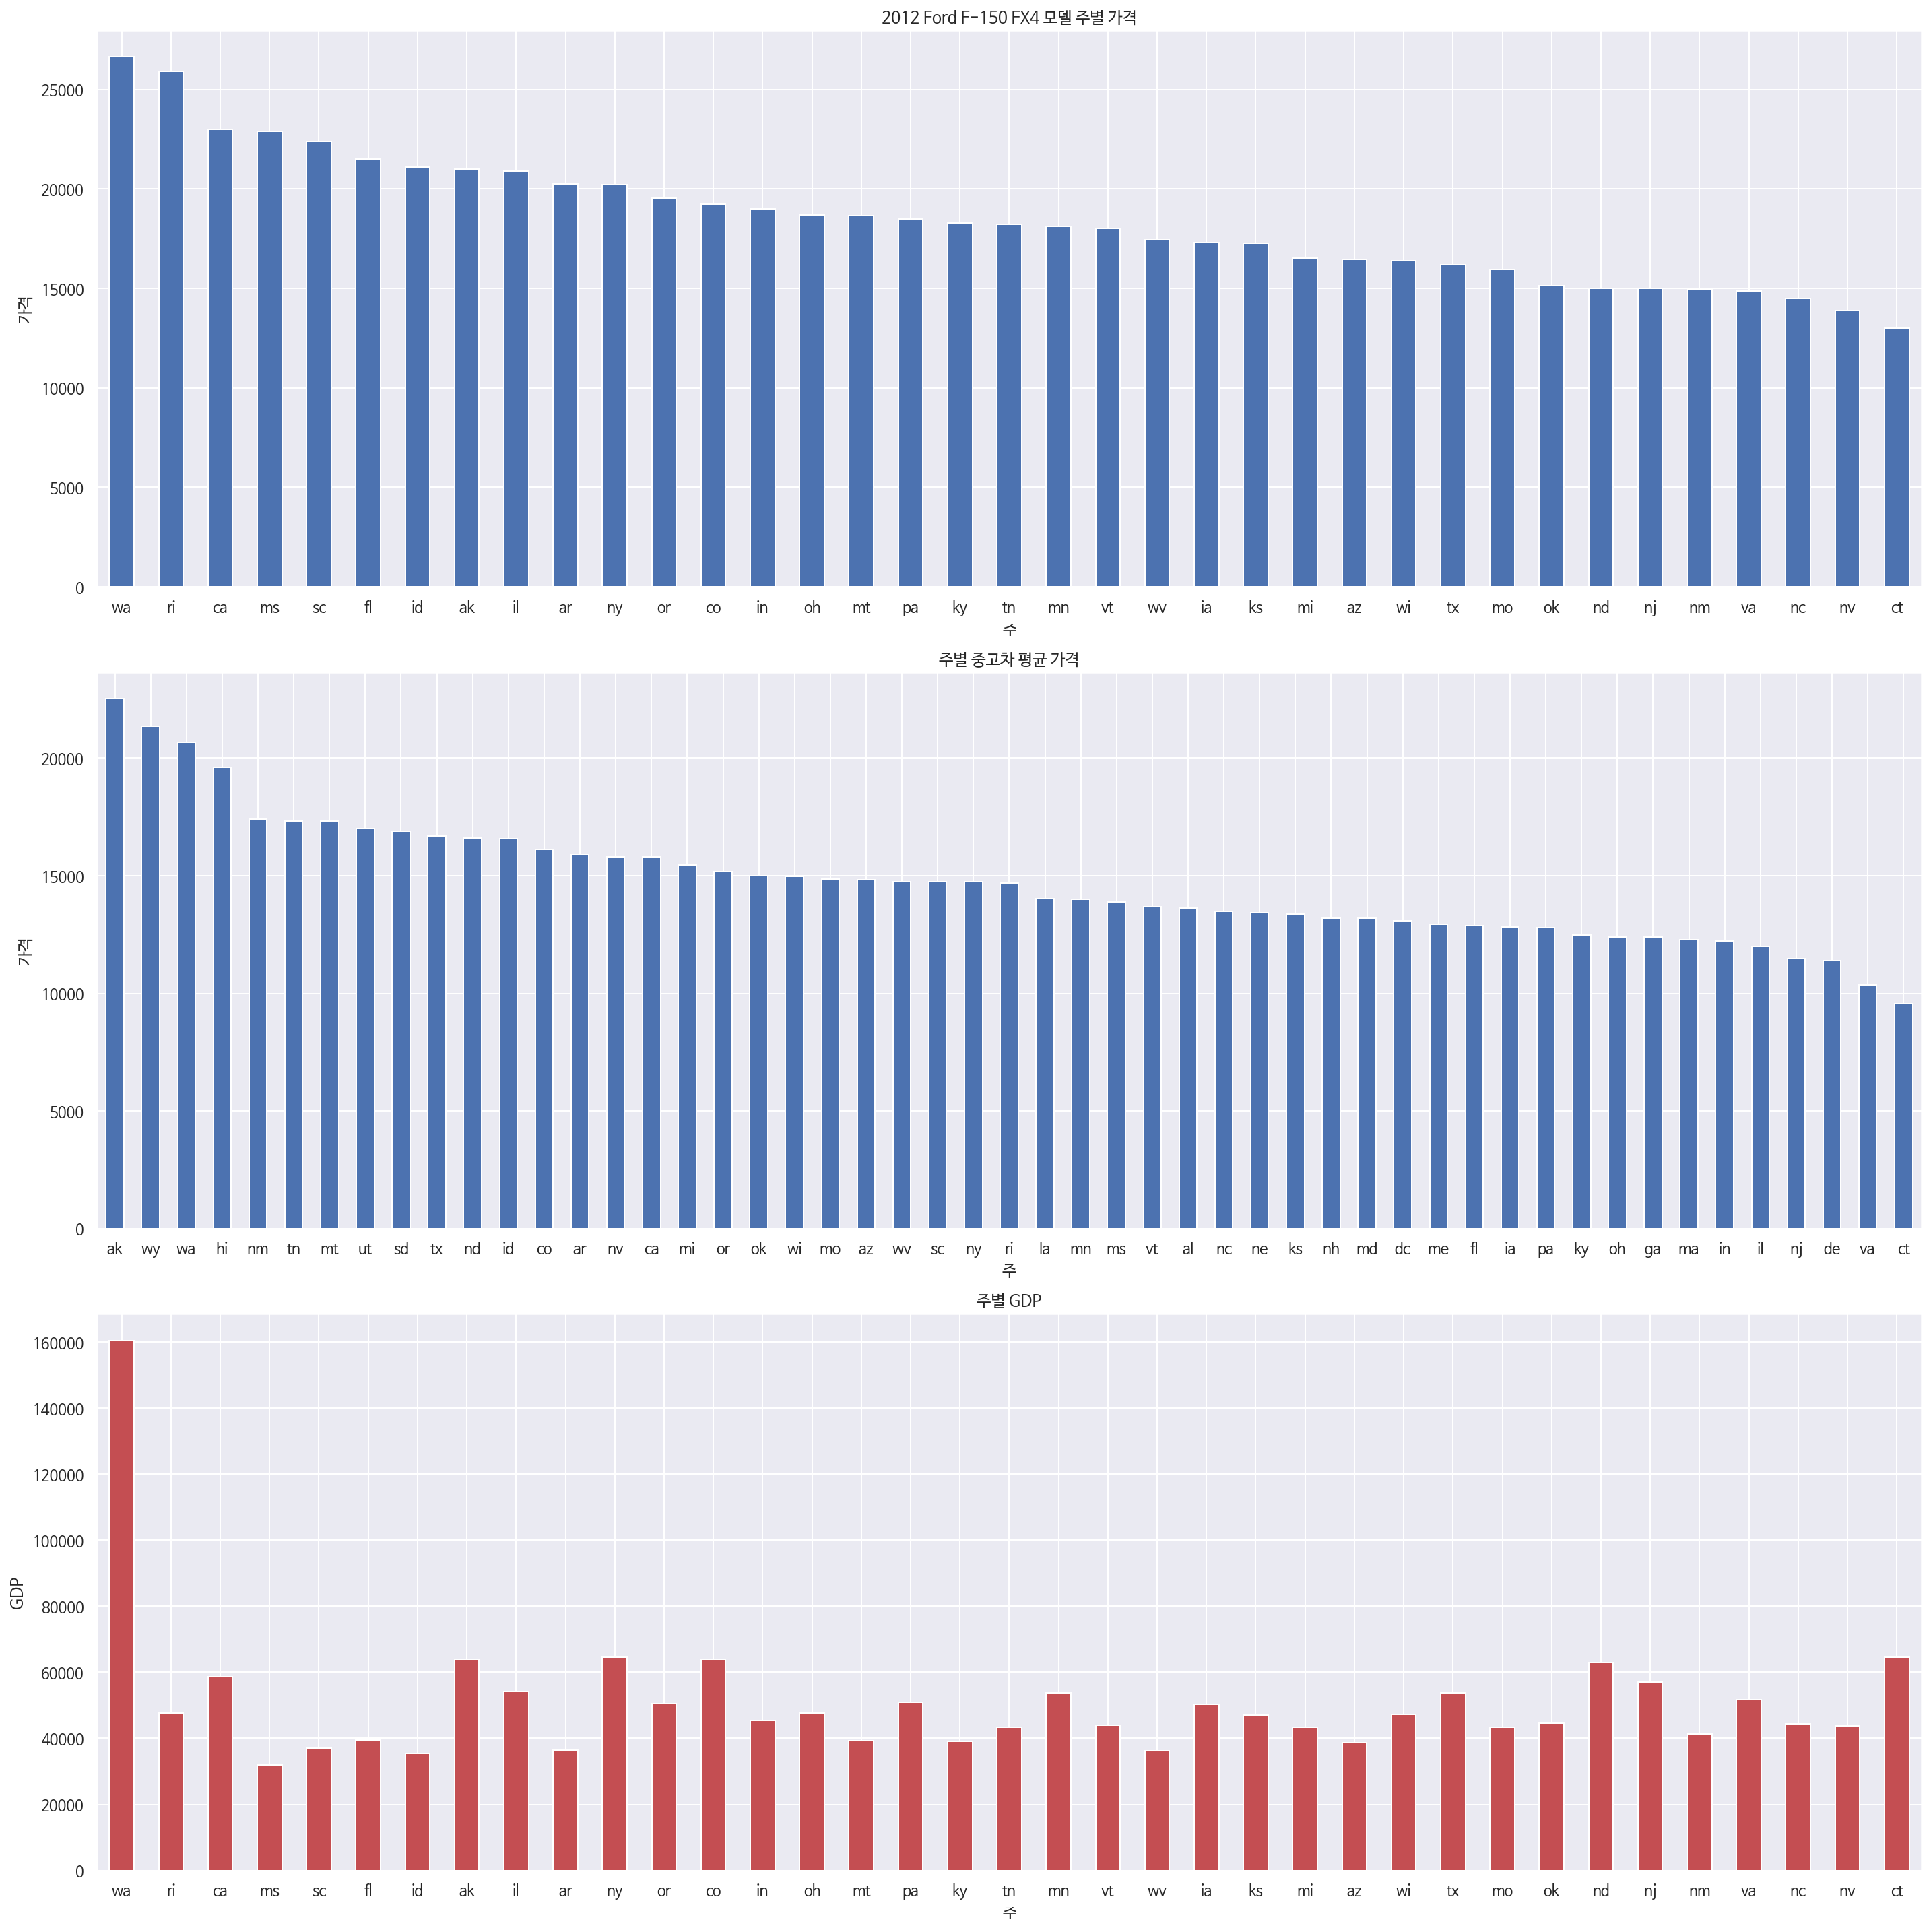

In [1019]:
plt.figure(figsize=(20,20))
plt.subplot(311)
Ford_f_150.plot(kind='bar', y='state')
plt.title("2012 Ford F-150 FX4 모델 주별 가격")
plt.xlabel("주")
plt.ylabel("가격")
plt.xticks(rotation=0)

plt.subplot(312)
test.plot(kind='bar', y='state')
plt.title("주별 중고차 평균 가격")
plt.xlabel("주")
plt.ylabel("가격")
plt.xticks(rotation=0)

plt.subplot(313)
pd.Series(gdp_per_cap).T.plot(kind='bar', color='r')
plt.title("주별 GDP")
plt.xlabel("주")
plt.ylabel("GDP")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [975]:
gdp_per_cap = {
    "wa": 160472,
    "ri" : 47639,
    "ca": 58619,
    "ms" : 31881,
    "sc" : 37063,
    "fl" : 39543,
    'id' : 35466, 
    'ak' : 63971, 
    'il' : 54091,
    'ar' : 36368,
    'ny' : 64579,
    'or' : 50582,
    'co' : 63882,
    'in' : 45317 ,
    'oh' : 47567,
    'mt' : 39356,
    'pa' : 50997,
    'ky' : 38985,
    'tn' : 43267,
    'mn' : 53704,
    'vt' : 43946,
    'wv' : 36315,
    'ia' : 50315,
    'ks' : 46982,
    'mi' : 43372,
    'az' : 38590, 
    'wi' : 47266, 
    'tx' : 53795,
    'mo' : 43317,
    'ok' : 44623,
    'nd' : 62837,
    'nj' : 57084, 
    'nm' : 41348, 
    'va' : 51736,
    'nc' : 44325,
    'nv' : 43820,
    'ct' : 64511,
}

# 향후 프로젝트 진행 방향
- 변수간 상관관계 심층 분석
- 모델별 성능 평가
- 가설 증명

## 해결하지 못한 의문점
- 데이터 분할, 카테고리 변수
  - **Train-Test split**, **K-fold**
  - 부트스트래핑?
- ANOVA
  - 카테고리 독립변수간의 상관관계 분석 방식에 대한 의문

# VIF Factor ???

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

In [ ]:
vif.sort_values(by=['VIF Factor'], ascending=False).iloc[:20]

In [ ]:
test2.columns

In [ ]:
from statsmodels.graphics.api import interaction_plot, abline_plot

plt.figure(figsize=(10,8))
fig = interaction_plot(df['paint_color'], df['transmission'], np.log(df['price']), ms=10, ax=plt.gca())

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig = df.boxplot('price', 'fuel', ax=ax, grid=False)

In [ ]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

rehab_lm = ols('price ~ C(fuel)', data=test2).fit()
table9 = anova_lm(rehab_lm)
print(table9)

print(rehab_lm.model.data.orig_exog)

In [ ]:
rehab_lm = ols('price ~ C(cylinders)', data=test2).fit()
table9 = anova_lm(rehab_lm)
print(table9)

print(rehab_lm.model.data.orig_exog)

# 변수간 상관관계

# 모델별 성능 평가

# 가설 증명